# Modeling: Decision Tree and Logistic Regression

## Importing libraries

In [193]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, roc_curve, auc, confusion_matrix
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import _pickle as pickle

## Loading in the DataFrame

In [155]:
with open("final_df.pickle",'rb') as fp:
    final_df = pickle.load(fp)

## Preparing the Data

In [156]:
# Assigning appropriate variables for modeling
X = final_df.drop('price_will_increase?', axis=1)
y = final_df['price_will_increase?']

In [157]:
# Splitting the data 80/20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

#### Scaling the Data
Standardize features by removing the mean and scaling to unit variance

In [158]:
def scaling(X_train, X_test):
    scaler = StandardScaler()
    scaled_data_train = scaler.fit_transform(X_train)
    scaled_data_test = scaler.transform(X_test)

    #scaled_df_train = pd.DataFrame(scaled_data_train, columns=final_df.columns)
    return scaled_data_train, scaled_data_test

X_train, X_test = scaling(X_train, X_test)

### Function to measure each model's success

In [159]:
def print_metrics(test, preds):
    print("Precision Score: {}".format(precision_score(test, preds)))
    print("Recall Score: {}".format(recall_score(test, preds)))
    print("Accuracy Score: {}".format(accuracy_score(test, preds)))
    print("F1 Score: {}".format(f1_score(test, preds)))

#### Function to plot important features

In [227]:
def plot_feature_importances(model, X_train):
    X_train = pd.DataFrame(X_train, columns=X.columns)
    n_features = X_train.shape[1]
    plt.figure(figsize=(8,14))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), X_train.columns.values) 
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    plt.show()

#### Function to plot the confusion matrix

In [220]:
def plot_confusion_matrix(y_true, y_pred, labels=[False, 'Price up > 5%'], 
                          normalize=False, title=None, cmap=plt.cm.cividis):

    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(12,6))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=labels, yticklabels=labels,
           title=title,
           ylabel='ACTUAL',
           xlabel='PREDICTED')
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="crimson" if cm[i, j] > thresh else "crimson",
                    size=26)
    ax.grid(False)
    fig.tight_layout()
    return ax

## Modeling - Decision Tree

### Instantiating and fitting the Decision Tree model

In [160]:
from sklearn.tree import DecisionTreeClassifier 

In [251]:
classifier = DecisionTreeClassifier()
classifier.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

### Results from the Decision Tree model

In [252]:
# Predictions
y_pred = classifier.predict(X_test)

print_metrics(y_test, y_pred)

Precision Score: 0.6
Recall Score: 0.5769230769230769
Accuracy Score: 0.5870786516853933
F1 Score: 0.5882352941176471


In [190]:
# Area under the curve
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
print("AUC:", round(roc_auc, 4))

AUC: 0.5901


#### Plotting the most important features according to Decision Tree

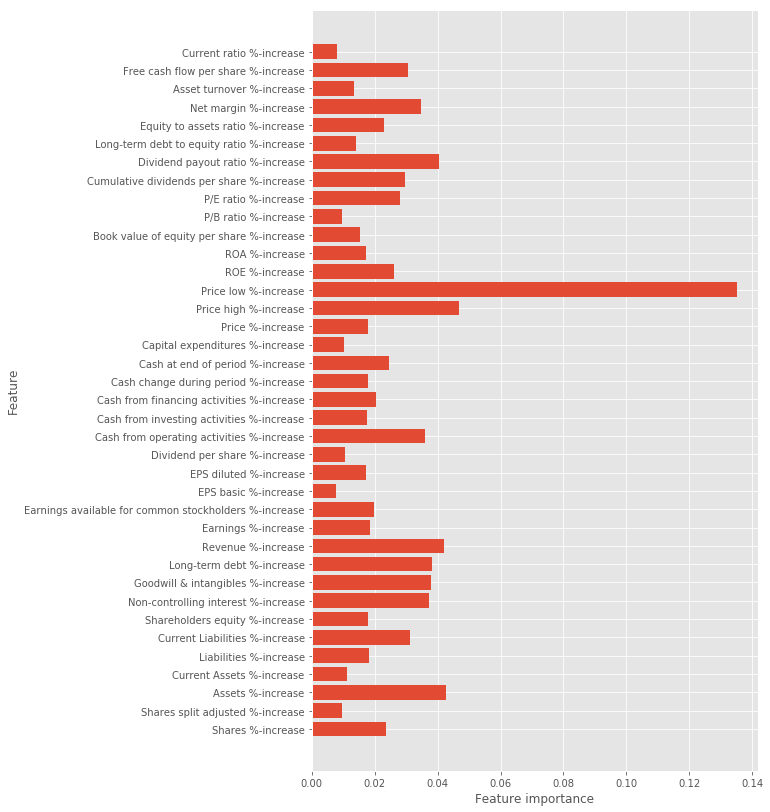

In [228]:
plot_feature_importances(classifier, X_train)

In [191]:
# Confusion Matrix
print("Confusion Matrix \n-----------------")
pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'], margins=True)

Confusion Matrix 
-----------------


Predicted,False,True,All
Actual,,,
False,104,70,174
True,76,106,182
All,180,176,356


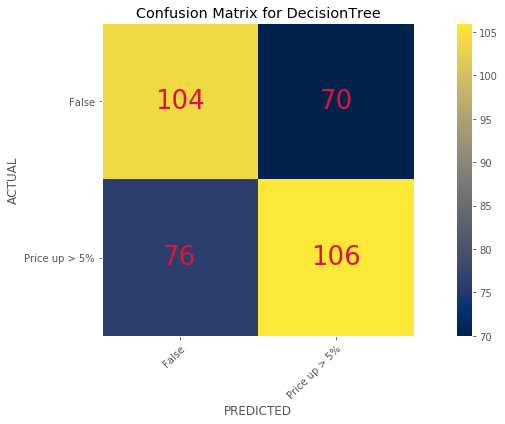

In [202]:
plot_confusion_matrix(y_test, y_pred, title="Confusion Matrix for DecisionTree")
np.set_printoptions(precision=1)
# Plot non-normalized confusion matrix
plt.show()

### Decision Tree - Accuracy: 58.98% and F1 Score: 59.21%.

### Improving Decision Tree with GridsearchCV

In [165]:
from sklearn.model_selection import GridSearchCV, cross_val_score

In [166]:
# Using Cross Validation
dt_clf = DecisionTreeClassifier()
dt_cv_score = cross_val_score(dt_clf, X, y, cv=3)
mean_dt_cv_score = np.mean(dt_cv_score)

print("Mean Cross Validation Score:", mean_dt_cv_score*100)

Mean Cross Validation Score: 54.269420936087606


In [167]:
dt_param_grid = {'criterion': ['gini', 'entropy'],
                 'max_depth': [None, 2, 3, 4, 5, 6],
                 'min_samples_split': [2, 5, 10],
                 'min_samples_leaf': [1,2,3,4,5,6]}

#### Using GridSearchCV
Finding the best parameters for the DecisionTree Model.

In [168]:
dt_grid_search = GridSearchCV(dt_clf, dt_param_grid, cv=3, return_train_score=True, verbose=5)
dt_grid_search.fit(X, y)

Fitting 3 folds for each of 216 candidates, totalling 648 fits
[CV] criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=2 
[CV]  criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=2, score=0.5791245791245792, total=   0.0s
[CV] criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=2 
[CV]  criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=2, score=0.5303030303030303, total=   0.0s
[CV] criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=2 
[CV]  criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=2, score=0.5506756756756757, total=   0.0s
[CV] criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=5 
[CV]  criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=5, score=0.5774410774410774, total=   0.0s
[CV] criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=5 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s


[CV]  criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=5, score=0.5404040404040404, total=   0.0s
[CV] criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=5 
[CV]  criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=5, score=0.5557432432432432, total=   0.0s
[CV] criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=10 
[CV]  criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=10, score=0.5538720538720538, total=   0.0s
[CV] criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=10 
[CV]  criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=10, score=0.5235690235690236, total=   0.0s
[CV] criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=10 
[CV]  criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=10, score=0.5523648648648649, total=   0.0s
[CV] criterion=gini, max_depth=None, min_samples_leaf=2, min_samples_split=2 
[CV]  cri

[CV]  criterion=gini, max_depth=None, min_samples_leaf=6, min_samples_split=5, score=0.5337837837837838, total=   0.1s
[CV] criterion=gini, max_depth=None, min_samples_leaf=6, min_samples_split=10 
[CV]  criterion=gini, max_depth=None, min_samples_leaf=6, min_samples_split=10, score=0.5791245791245792, total=   0.1s
[CV] criterion=gini, max_depth=None, min_samples_leaf=6, min_samples_split=10 
[CV]  criterion=gini, max_depth=None, min_samples_leaf=6, min_samples_split=10, score=0.5521885521885522, total=   0.0s
[CV] criterion=gini, max_depth=None, min_samples_leaf=6, min_samples_split=10 
[CV]  criterion=gini, max_depth=None, min_samples_leaf=6, min_samples_split=10, score=0.5456081081081081, total=   0.0s
[CV] criterion=gini, max_depth=2, min_samples_leaf=1, min_samples_split=2 
[CV]  criterion=gini, max_depth=2, min_samples_leaf=1, min_samples_split=2, score=0.5959595959595959, total=   0.0s
[CV] criterion=gini, max_depth=2, min_samples_leaf=1, min_samples_split=2 
[CV]  criterion=gi

[CV]  criterion=gini, max_depth=2, min_samples_leaf=6, min_samples_split=2, score=0.6077441077441077, total=   0.0s
[CV] criterion=gini, max_depth=2, min_samples_leaf=6, min_samples_split=2 
[CV]  criterion=gini, max_depth=2, min_samples_leaf=6, min_samples_split=2, score=0.6266891891891891, total=   0.0s
[CV] criterion=gini, max_depth=2, min_samples_leaf=6, min_samples_split=5 
[CV]  criterion=gini, max_depth=2, min_samples_leaf=6, min_samples_split=5, score=0.5959595959595959, total=   0.0s
[CV] criterion=gini, max_depth=2, min_samples_leaf=6, min_samples_split=5 
[CV]  criterion=gini, max_depth=2, min_samples_leaf=6, min_samples_split=5, score=0.6077441077441077, total=   0.0s
[CV] criterion=gini, max_depth=2, min_samples_leaf=6, min_samples_split=5 
[CV]  criterion=gini, max_depth=2, min_samples_leaf=6, min_samples_split=5, score=0.6266891891891891, total=   0.0s
[CV] criterion=gini, max_depth=2, min_samples_leaf=6, min_samples_split=10 
[CV]  criterion=gini, max_depth=2, min_sampl

[CV]  criterion=gini, max_depth=3, min_samples_leaf=5, min_samples_split=10, score=0.5925925925925926, total=   0.0s
[CV] criterion=gini, max_depth=3, min_samples_leaf=5, min_samples_split=10 
[CV]  criterion=gini, max_depth=3, min_samples_leaf=5, min_samples_split=10, score=0.5827702702702703, total=   0.0s
[CV] criterion=gini, max_depth=3, min_samples_leaf=6, min_samples_split=2 
[CV]  criterion=gini, max_depth=3, min_samples_leaf=6, min_samples_split=2, score=0.5841750841750841, total=   0.0s
[CV] criterion=gini, max_depth=3, min_samples_leaf=6, min_samples_split=2 
[CV]  criterion=gini, max_depth=3, min_samples_leaf=6, min_samples_split=2, score=0.5925925925925926, total=   0.0s
[CV] criterion=gini, max_depth=3, min_samples_leaf=6, min_samples_split=2 
[CV]  criterion=gini, max_depth=3, min_samples_leaf=6, min_samples_split=2, score=0.5827702702702703, total=   0.0s
[CV] criterion=gini, max_depth=3, min_samples_leaf=6, min_samples_split=5 
[CV]  criterion=gini, max_depth=3, min_sam

[CV]  criterion=gini, max_depth=4, min_samples_leaf=4, min_samples_split=10, score=0.5909090909090909, total=   0.0s
[CV] criterion=gini, max_depth=4, min_samples_leaf=4, min_samples_split=10 
[CV]  criterion=gini, max_depth=4, min_samples_leaf=4, min_samples_split=10, score=0.5740740740740741, total=   0.0s
[CV] criterion=gini, max_depth=4, min_samples_leaf=4, min_samples_split=10 
[CV]  criterion=gini, max_depth=4, min_samples_leaf=4, min_samples_split=10, score=0.5709459459459459, total=   0.0s
[CV] criterion=gini, max_depth=4, min_samples_leaf=5, min_samples_split=2 
[CV]  criterion=gini, max_depth=4, min_samples_leaf=5, min_samples_split=2, score=0.5942760942760943, total=   0.0s
[CV] criterion=gini, max_depth=4, min_samples_leaf=5, min_samples_split=2 
[CV]  criterion=gini, max_depth=4, min_samples_leaf=5, min_samples_split=2, score=0.5740740740740741, total=   0.0s
[CV] criterion=gini, max_depth=4, min_samples_leaf=5, min_samples_split=2 
[CV]  criterion=gini, max_depth=4, min_s

[CV]  criterion=gini, max_depth=5, min_samples_leaf=4, min_samples_split=2, score=0.5976430976430976, total=   0.0s
[CV] criterion=gini, max_depth=5, min_samples_leaf=4, min_samples_split=2 
[CV]  criterion=gini, max_depth=5, min_samples_leaf=4, min_samples_split=2, score=0.5962837837837838, total=   0.0s
[CV] criterion=gini, max_depth=5, min_samples_leaf=4, min_samples_split=5 
[CV]  criterion=gini, max_depth=5, min_samples_leaf=4, min_samples_split=5, score=0.5875420875420876, total=   0.0s
[CV] criterion=gini, max_depth=5, min_samples_leaf=4, min_samples_split=5 
[CV]  criterion=gini, max_depth=5, min_samples_leaf=4, min_samples_split=5, score=0.5993265993265994, total=   0.0s
[CV] criterion=gini, max_depth=5, min_samples_leaf=4, min_samples_split=5 
[CV]  criterion=gini, max_depth=5, min_samples_leaf=4, min_samples_split=5, score=0.5962837837837838, total=   0.0s
[CV] criterion=gini, max_depth=5, min_samples_leaf=4, min_samples_split=10 
[CV]  criterion=gini, max_depth=5, min_sampl

[CV]  criterion=gini, max_depth=6, min_samples_leaf=3, min_samples_split=2, score=0.5942760942760943, total=   0.0s
[CV] criterion=gini, max_depth=6, min_samples_leaf=3, min_samples_split=2 
[CV]  criterion=gini, max_depth=6, min_samples_leaf=3, min_samples_split=2, score=0.5740740740740741, total=   0.0s
[CV] criterion=gini, max_depth=6, min_samples_leaf=3, min_samples_split=2 
[CV]  criterion=gini, max_depth=6, min_samples_leaf=3, min_samples_split=2, score=0.581081081081081, total=   0.0s
[CV] criterion=gini, max_depth=6, min_samples_leaf=3, min_samples_split=5 
[CV]  criterion=gini, max_depth=6, min_samples_leaf=3, min_samples_split=5, score=0.5875420875420876, total=   0.0s
[CV] criterion=gini, max_depth=6, min_samples_leaf=3, min_samples_split=5 
[CV]  criterion=gini, max_depth=6, min_samples_leaf=3, min_samples_split=5, score=0.5723905723905723, total=   0.0s
[CV] criterion=gini, max_depth=6, min_samples_leaf=3, min_samples_split=5 
[CV]  criterion=gini, max_depth=6, min_samples

[CV]  criterion=entropy, max_depth=None, min_samples_leaf=1, min_samples_split=10, score=0.5740740740740741, total=   0.1s
[CV] criterion=entropy, max_depth=None, min_samples_leaf=1, min_samples_split=10 
[CV]  criterion=entropy, max_depth=None, min_samples_leaf=1, min_samples_split=10, score=0.5523648648648649, total=   0.0s
[CV] criterion=entropy, max_depth=None, min_samples_leaf=2, min_samples_split=2 
[CV]  criterion=entropy, max_depth=None, min_samples_leaf=2, min_samples_split=2, score=0.5673400673400674, total=   0.1s
[CV] criterion=entropy, max_depth=None, min_samples_leaf=2, min_samples_split=2 
[CV]  criterion=entropy, max_depth=None, min_samples_leaf=2, min_samples_split=2, score=0.5471380471380471, total=   0.1s
[CV] criterion=entropy, max_depth=None, min_samples_leaf=2, min_samples_split=2 
[CV]  criterion=entropy, max_depth=None, min_samples_leaf=2, min_samples_split=2, score=0.5641891891891891, total=   0.0s
[CV] criterion=entropy, max_depth=None, min_samples_leaf=2, min

[CV]  criterion=entropy, max_depth=None, min_samples_leaf=6, min_samples_split=5, score=0.5370370370370371, total=   0.1s
[CV] criterion=entropy, max_depth=None, min_samples_leaf=6, min_samples_split=5 
[CV]  criterion=entropy, max_depth=None, min_samples_leaf=6, min_samples_split=5, score=0.5606060606060606, total=   0.1s
[CV] criterion=entropy, max_depth=None, min_samples_leaf=6, min_samples_split=5 
[CV]  criterion=entropy, max_depth=None, min_samples_leaf=6, min_samples_split=5, score=0.5304054054054054, total=   0.0s
[CV] criterion=entropy, max_depth=None, min_samples_leaf=6, min_samples_split=10 
[CV]  criterion=entropy, max_depth=None, min_samples_leaf=6, min_samples_split=10, score=0.5404040404040404, total=   0.0s
[CV] criterion=entropy, max_depth=None, min_samples_leaf=6, min_samples_split=10 
[CV]  criterion=entropy, max_depth=None, min_samples_leaf=6, min_samples_split=10, score=0.563973063973064, total=   0.1s
[CV] criterion=entropy, max_depth=None, min_samples_leaf=6, min

[CV]  criterion=entropy, max_depth=2, min_samples_leaf=5, min_samples_split=2, score=0.6266891891891891, total=   0.0s
[CV] criterion=entropy, max_depth=2, min_samples_leaf=5, min_samples_split=5 
[CV]  criterion=entropy, max_depth=2, min_samples_leaf=5, min_samples_split=5, score=0.5959595959595959, total=   0.0s
[CV] criterion=entropy, max_depth=2, min_samples_leaf=5, min_samples_split=5 
[CV]  criterion=entropy, max_depth=2, min_samples_leaf=5, min_samples_split=5, score=0.6077441077441077, total=   0.0s
[CV] criterion=entropy, max_depth=2, min_samples_leaf=5, min_samples_split=5 
[CV]  criterion=entropy, max_depth=2, min_samples_leaf=5, min_samples_split=5, score=0.6266891891891891, total=   0.0s
[CV] criterion=entropy, max_depth=2, min_samples_leaf=5, min_samples_split=10 
[CV]  criterion=entropy, max_depth=2, min_samples_leaf=5, min_samples_split=10, score=0.5959595959595959, total=   0.0s
[CV] criterion=entropy, max_depth=2, min_samples_leaf=5, min_samples_split=10 
[CV]  criter

[CV]  criterion=entropy, max_depth=3, min_samples_leaf=4, min_samples_split=5, score=0.601010101010101, total=   0.0s
[CV] criterion=entropy, max_depth=3, min_samples_leaf=4, min_samples_split=5 
[CV]  criterion=entropy, max_depth=3, min_samples_leaf=4, min_samples_split=5, score=0.5878378378378378, total=   0.0s
[CV] criterion=entropy, max_depth=3, min_samples_leaf=4, min_samples_split=10 
[CV]  criterion=entropy, max_depth=3, min_samples_leaf=4, min_samples_split=10, score=0.5841750841750841, total=   0.0s
[CV] criterion=entropy, max_depth=3, min_samples_leaf=4, min_samples_split=10 
[CV]  criterion=entropy, max_depth=3, min_samples_leaf=4, min_samples_split=10, score=0.601010101010101, total=   0.0s
[CV] criterion=entropy, max_depth=3, min_samples_leaf=4, min_samples_split=10 
[CV]  criterion=entropy, max_depth=3, min_samples_leaf=4, min_samples_split=10, score=0.5878378378378378, total=   0.0s
[CV] criterion=entropy, max_depth=3, min_samples_leaf=5, min_samples_split=2 
[CV]  crite

[CV]  criterion=entropy, max_depth=4, min_samples_leaf=3, min_samples_split=10, score=0.5641891891891891, total=   0.0s
[CV] criterion=entropy, max_depth=4, min_samples_leaf=4, min_samples_split=2 
[CV]  criterion=entropy, max_depth=4, min_samples_leaf=4, min_samples_split=2, score=0.5976430976430976, total=   0.0s
[CV] criterion=entropy, max_depth=4, min_samples_leaf=4, min_samples_split=2 
[CV]  criterion=entropy, max_depth=4, min_samples_leaf=4, min_samples_split=2, score=0.5858585858585859, total=   0.0s
[CV] criterion=entropy, max_depth=4, min_samples_leaf=4, min_samples_split=2 
[CV]  criterion=entropy, max_depth=4, min_samples_leaf=4, min_samples_split=2, score=0.5641891891891891, total=   0.0s
[CV] criterion=entropy, max_depth=4, min_samples_leaf=4, min_samples_split=5 
[CV]  criterion=entropy, max_depth=4, min_samples_leaf=4, min_samples_split=5, score=0.5976430976430976, total=   0.0s
[CV] criterion=entropy, max_depth=4, min_samples_leaf=4, min_samples_split=5 
[CV]  criterio

[CV]  criterion=entropy, max_depth=5, min_samples_leaf=2, min_samples_split=10, score=0.5942760942760943, total=   0.0s
[CV] criterion=entropy, max_depth=5, min_samples_leaf=2, min_samples_split=10 
[CV]  criterion=entropy, max_depth=5, min_samples_leaf=2, min_samples_split=10, score=0.5959595959595959, total=   0.0s
[CV] criterion=entropy, max_depth=5, min_samples_leaf=2, min_samples_split=10 
[CV]  criterion=entropy, max_depth=5, min_samples_leaf=2, min_samples_split=10, score=0.5692567567567568, total=   0.0s
[CV] criterion=entropy, max_depth=5, min_samples_leaf=3, min_samples_split=2 
[CV]  criterion=entropy, max_depth=5, min_samples_leaf=3, min_samples_split=2, score=0.5959595959595959, total=   0.0s
[CV] criterion=entropy, max_depth=5, min_samples_leaf=3, min_samples_split=2 
[CV]  criterion=entropy, max_depth=5, min_samples_leaf=3, min_samples_split=2, score=0.5959595959595959, total=   0.0s
[CV] criterion=entropy, max_depth=5, min_samples_leaf=3, min_samples_split=2 
[CV]  crit

[CV]  criterion=entropy, max_depth=6, min_samples_leaf=1, min_samples_split=10, score=0.5942760942760943, total=   0.0s
[CV] criterion=entropy, max_depth=6, min_samples_leaf=1, min_samples_split=10 
[CV]  criterion=entropy, max_depth=6, min_samples_leaf=1, min_samples_split=10, score=0.5726351351351351, total=   0.0s
[CV] criterion=entropy, max_depth=6, min_samples_leaf=2, min_samples_split=2 
[CV]  criterion=entropy, max_depth=6, min_samples_leaf=2, min_samples_split=2, score=0.5875420875420876, total=   0.0s
[CV] criterion=entropy, max_depth=6, min_samples_leaf=2, min_samples_split=2 
[CV]  criterion=entropy, max_depth=6, min_samples_leaf=2, min_samples_split=2, score=0.5791245791245792, total=   0.0s
[CV] criterion=entropy, max_depth=6, min_samples_leaf=2, min_samples_split=2 
[CV]  criterion=entropy, max_depth=6, min_samples_leaf=2, min_samples_split=2, score=0.5641891891891891, total=   0.0s
[CV] criterion=entropy, max_depth=6, min_samples_leaf=2, min_samples_split=5 
[CV]  criter

[Parallel(n_jobs=1)]: Done 648 out of 648 | elapsed:   17.3s finished


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'criterion': ['gini', 'entropy'], 'max_depth': [None, 2, 3, 4, 5, 6], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 3, 4, 5, 6]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=5)

In [169]:
dt_gs_training_score = np.mean(dt_grid_search.cv_results_['mean_train_score'])
dt_gs_testing_score = dt_grid_search.score(X, y)

print("Mean Training Score:", dt_gs_training_score*100)
print("Mean Testing Score:", dt_gs_testing_score*100)
print("Best Parameter Found:")
dt_grid_search.best_params_

Mean Training Score: 71.03486031033239
Mean Testing Score: 62.19101123595505
Best Parameter Found:


{'criterion': 'gini',
 'max_depth': 2,
 'min_samples_leaf': 1,
 'min_samples_split': 2}

### Running the Decision Tree model with the best parameters according to GridSearchCV

In [265]:
classifier_gs = dt_grid_search.best_estimator_
classifier_gs.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

### Results from the GridSearch Parameters for Decision Tree

In [266]:
# Predictions with GridSearch Params
y_pred_gs = classifier_gs.predict(X_test)

print_metrics(y_test, y_pred_gs)

Precision Score: 0.5736434108527132
Recall Score: 0.8131868131868132
Accuracy Score: 0.5955056179775281
F1 Score: 0.6727272727272728


In [197]:
# Area under the Curve with GS Params
false_positive_rate_gs, true_positive_rate_gs, thresholds = roc_curve(y_test, y_pred_gs)
roc_auc_gs = auc(false_positive_rate_gs, true_positive_rate_gs)
print("AUC:", round(roc_auc_gs, 4))

AUC: 0.5905


In [198]:
# Confusion Matrix from Gridsearch Params
print("Confusion Matrix \n-----------------")
pd.crosstab(y_test, y_pred_gs, rownames=['Actual'], colnames=['Predicted'], margins=True)

Confusion Matrix 
-----------------


Predicted,False,True,All
Actual,,,
False,64,110,174
True,34,148,182
All,98,258,356


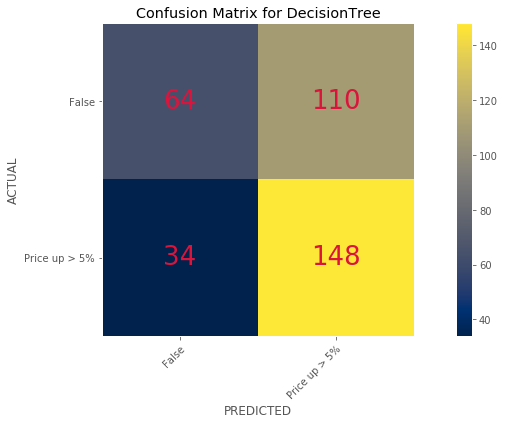

In [222]:
plot_confusion_matrix(y_test, y_pred_gs, title="Confusion Matrix for DecisionTree")
np.set_printoptions(precision=1)
# Plot non-normalized confusion matrix
plt.savefig('DTConMat.png')
plt.show()

### Decision Tree (w/GridSearch) Accuracy: 59.55% and F1 Score: 67.27%.

## Modeling - Logistic Regression

In [174]:
from sklearn.linear_model import LogisticRegression

### Fitting and Training Logistic Regression

In [214]:
logreg = LogisticRegression(fit_intercept=False, C=1e16)
logreg.fit(X_train, y_train)

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1e+16, class_weight=None, dual=False,
          fit_intercept=False, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

### Measuring the results from Logistic Regression

In [215]:
# Predictions from LR
y_pred = logreg.predict(X_test)

print_metrics(y_test, y_pred)

Precision Score: 0.5555555555555556
Recall Score: 0.6318681318681318
Accuracy Score: 0.5533707865168539
F1 Score: 0.5912596401028278


In [216]:
log_fpr, log_tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(log_fpr, log_tpr)
print("AUC:", round(roc_auc, 4))

AUC: 0.5516


### Logistic Regression - Accuracy: 55.33% and F1 Score: 59.12%.

### Plotting the ROC Curve

Test AUC: 0.5909435392194013
Train AUC: 0.6497392134583214


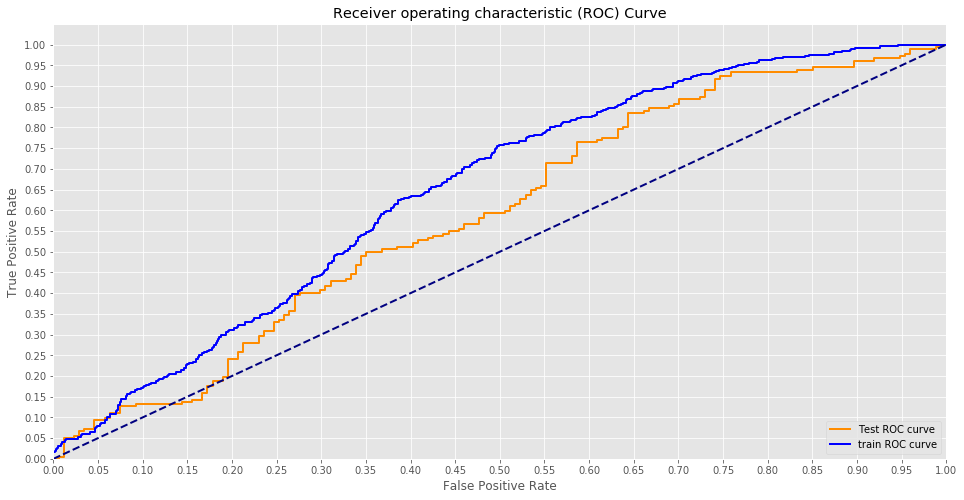

In [217]:
y_test_score  = logreg.decision_function(X_test)
y_train_score = logreg.decision_function(X_train)

# True and False Positive Rates for the Test and Train sets
test_fpr, test_tpr, test_thresholds = roc_curve(y_test, y_test_score)
train_fpr, train_tpr, train_thresholds = roc_curve(y_train, y_train_score)

print("Test AUC:", auc(test_fpr, test_tpr))
print("Train AUC:", auc(train_fpr, train_tpr))

# Plotting
plt.figure(figsize=(16,8))
lw = 2
plt.plot(test_fpr, test_tpr, color='darkorange',
         lw=lw, label='Test ROC curve')
plt.plot(train_fpr, train_tpr, color='blue',
         lw=lw, label='train ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

### Confusion Matrix

In [218]:
# Confusion Matrix from Gridsearch Params
print("Confusion Matrix \n-----------------")
pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'], margins=True)

Confusion Matrix 
-----------------


Predicted,False,True,All
Actual,,,
False,82,92,174
True,67,115,182
All,149,207,356


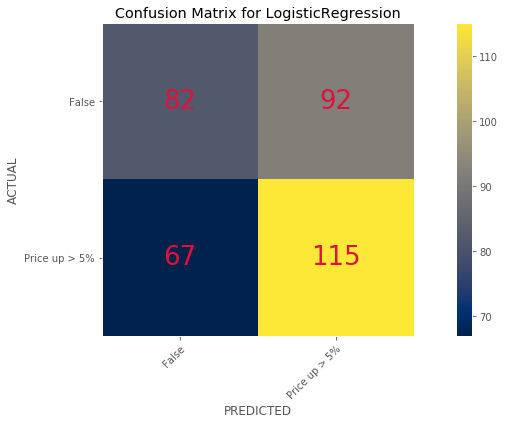

In [219]:
plot_confusion_matrix(y_test, y_pred, title="Confusion Matrix for LogisticRegression")
np.set_printoptions(precision=1)
# Plot non-normalized confusion matrix
plt.show()

### Logistic Regression - Accuracy: 55.33% and F1 Score: 59.12%.

### Improving Logistic Regression with GridSearchCV

In [179]:
# Using Cross Validation
log_clf = LogisticRegression()
log_cv_score = cross_val_score(log_clf, X, y, cv=3)
mean_log_cv_score = np.mean(log_cv_score)

print("Mean Cross Validation Score:", mean_log_cv_score*100)

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Mean Cross Validation Score: 58.371818788485456


In [180]:
log_param_grid = {'C': [1.5**n for n in range(0, 20, 2)],
                  'fit_intercept': [True, False],
                  'intercept_scaling': [1, 5, 10, 25, 50, 100],
                  'solver': ['liblinear', 'saga']}

In [181]:
log_grid_search = GridSearchCV(log_clf, log_param_grid, cv=3, return_train_score=True, verbose=3)
log_grid_search.fit(X, y)

Fitting 3 folds for each of 240 candidates, totalling 720 fits
[CV] C=1.0, fit_intercept=True, intercept_scaling=1, solver=liblinear 
[CV]  C=1.0, fit_intercept=True, intercept_scaling=1, solver=liblinear, score=0.5791245791245792, total=   0.2s
[CV] C=1.0, fit_intercept=True, intercept_scaling=1, solver=liblinear 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV]  C=1.0, fit_intercept=True, intercept_scaling=1, solver=liblinear, score=0.5791245791245792, total=   0.1s
[CV] C=1.0, fit_intercept=True, intercept_scaling=1, solver=liblinear 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s


[CV]  C=1.0, fit_intercept=True, intercept_scaling=1, solver=liblinear, score=0.5929054054054054, total=   0.2s
[CV] C=1.0, fit_intercept=True, intercept_scaling=1, solver=saga .....
[CV]  C=1.0, fit_intercept=True, intercept_scaling=1, solver=saga, score=0.49663299663299665, total=   0.1s
[CV] C=1.0, fit_intercept=True, intercept_scaling=1, solver=saga .....
[CV]  C=1.0, fit_intercept=True, intercept_scaling=1, solver=saga, score=0.51010101010101, total=   0.1s
[CV] C=1.0, fit_intercept=True, intercept_scaling=1, solver=saga .....


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=1.0, fit_intercept=True, intercept_scaling=1, solver=saga, score=0.5135135135135135, total=   0.1s
[CV] C=1.0, fit_intercept=True, intercept_scaling=5, solver=liblinear 
[CV]  C=1.0, fit_intercept=True, intercept_scaling=5, solver=liblinear, score=0.5791245791245792, total=   0.3s
[CV] C=1.0, fit_intercept=True, intercept_scaling=5, solver=liblinear 
[CV]  C=1.0, fit_intercept=True, intercept_scaling=5, solver=liblinear, score=0.5808080808080808, total=   0.1s
[CV] C=1.0, fit_intercept=True, intercept_scaling=5, solver=liblinear 
[CV]  C=1.0, fit_intercept=True, intercept_scaling=5, solver=liblinear, score=0.5945945945945946, total=   0.2s
[CV] C=1.0, fit_intercept=True, intercept_scaling=5, solver=saga .....
[CV]  C=1.0, fit_intercept=True, intercept_scaling=5, solver=saga, score=0.5, total=   0.1s
[CV] C=1.0, fit_intercept=True, intercept_scaling=5, solver=saga .....
[CV]  C=1.0, fit_intercept=True, intercept_scaling=5, solver=saga, score=0.5168350168350169, total=   0.1s
[CV

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=1.0, fit_intercept=True, intercept_scaling=5, solver=saga, score=0.5135135135135135, total=   0.1s
[CV] C=1.0, fit_intercept=True, intercept_scaling=10, solver=liblinear 
[CV]  C=1.0, fit_intercept=True, intercept_scaling=10, solver=liblinear, score=0.5925925925925926, total=   0.1s
[CV] C=1.0, fit_intercept=True, intercept_scaling=10, solver=liblinear 


/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  C=1.0, fit_intercept=True, intercept_scaling=10, solver=liblinear, score=0.5808080808080808, total=   0.1s
[CV] C=1.0, fit_intercept=True, intercept_scaling=10, solver=liblinear 
[CV]  C=1.0, fit_intercept=True, intercept_scaling=10, solver=liblinear, score=0.5945945945945946, total=   0.3s
[CV] C=1.0, fit_intercept=True, intercept_scaling=10, solver=saga ....
[CV]  C=1.0, fit_intercept=True, intercept_scaling=10, solver=saga, score=0.4983164983164983, total=   0.1s
[CV] C=1.0, fit_intercept=True, intercept_scaling=10, solver=saga ....
[CV]  C=1.0, fit_intercept=True, intercept_scaling=10, solver=saga, score=0.5117845117845118, total=   0.1s
[CV] C=1.0, fit_intercept=True, intercept_scaling=10, solver=saga ....
[CV]  C=1.0, fit_intercept=True, intercept_scaling=10, solver=saga, score=0.5118243243243243, total=   0.1s
[CV] C=1.0, fit_intercept=True, intercept_scaling=25, solver=liblinear 


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  C=1.0, fit_intercept=True, intercept_scaling=25, solver=liblinear, score=0.5808080808080808, total=   0.1s
[CV] C=1.0, fit_intercept=True, intercept_scaling=25, solver=liblinear 
[CV]  C=1.0, fit_intercept=True, intercept_scaling=25, solver=liblinear, score=0.5791245791245792, total=   0.1s
[CV] C=1.0, fit_intercept=True, intercept_scaling=25, solver=liblinear 


/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=1.0, fit_intercept=True, intercept_scaling=25, solver=liblinear, score=0.5929054054054054, total=   0.3s
[CV] C=1.0, fit_intercept=True, intercept_scaling=25, solver=saga ....
[CV]  C=1.0, fit_intercept=True, intercept_scaling=25, solver=saga, score=0.5, total=   0.1s
[CV] C=1.0, fit_intercept=True, intercept_scaling=25, solver=saga ....
[CV]  C=1.0, fit_intercept=True, intercept_scaling=25, solver=saga, score=0.5168350168350169, total=   0.1s
[CV] C=1.0, fit_intercept=True, intercept_scaling=25, solver=saga ....
[CV]  C=1.0, fit_intercept=True, intercept_scaling=25, solver=saga, score=0.5135135135135135, total=   0.1s
[CV] C=1.0, fit_intercept=True, intercept_scaling=50, solver=liblinear 


/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  C=1.0, fit_intercept=True, intercept_scaling=50, solver=liblinear, score=0.5808080808080808, total=   0.2s
[CV] C=1.0, fit_intercept=True, intercept_scaling=50, solver=liblinear 
[CV]  C=1.0, fit_intercept=True, intercept_scaling=50, solver=liblinear, score=0.5791245791245792, total=   0.2s
[CV] C=1.0, fit_intercept=True, intercept_scaling=50, solver=liblinear 


/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=1.0, fit_intercept=True, intercept_scaling=50, solver=liblinear, score=0.5929054054054054, total=   0.3s
[CV] C=1.0, fit_intercept=True, intercept_scaling=50, solver=saga ....
[CV]  C=1.0, fit_intercept=True, intercept_scaling=50, solver=saga, score=0.5, total=   0.1s
[CV] C=1.0, fit_intercept=True, intercept_scaling=50, solver=saga ....
[CV]  C=1.0, fit_intercept=True, intercept_scaling=50, solver=saga, score=0.51010101010101, total=   0.1s
[CV] C=1.0, fit_intercept=True, intercept_scaling=50, solver=saga ....
[CV]  C=1.0, fit_intercept=True, intercept_scaling=50, solver=saga, score=0.5152027027027027, total=   0.1s
[CV] C=1.0, fit_intercept=True, intercept_scaling=100, solver=liblinear 


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=1.0, fit_intercept=True, intercept_scaling=100, solver=liblinear, score=0.5791245791245792, total=   0.3s
[CV] C=1.0, fit_intercept=True, intercept_scaling=100, solver=liblinear 
[CV]  C=1.0, fit_intercept=True, intercept_scaling=100, solver=liblinear, score=0.5808080808080808, total=   0.2s
[CV] C=1.0, fit_intercept=True, intercept_scaling=100, solver=liblinear 
[CV]  C=1.0, fit_intercept=True, intercept_scaling=100, solver=liblinear, score=0.5962837837837838, total=   0.3s
[CV] C=1.0, fit_intercept=True, intercept_scaling=100, solver=saga ...
[CV]  C=1.0, fit_intercept=True, intercept_scaling=100, solver=saga, score=0.4983164983164983, total=   0.1s
[CV] C=1.0, fit_intercept=True, intercept_scaling=100, solver=saga ...
[CV]  C=1.0, fit_intercept=True, intercept_scaling=100, solver=saga, score=0.5117845117845118, total=   0.1s
[CV] C=1.0, fit_intercept=True, intercept_scaling=100, solver=saga ...


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=1.0, fit_intercept=True, intercept_scaling=100, solver=saga, score=0.5135135135135135, total=   0.1s
[CV] C=1.0, fit_intercept=False, intercept_scaling=1, solver=liblinear 
[CV]  C=1.0, fit_intercept=False, intercept_scaling=1, solver=liblinear, score=0.5757575757575758, total=   0.3s
[CV] C=1.0, fit_intercept=False, intercept_scaling=1, solver=liblinear 
[CV]  C=1.0, fit_intercept=False, intercept_scaling=1, solver=liblinear, score=0.5757575757575758, total=   0.2s
[CV] C=1.0, fit_intercept=False, intercept_scaling=1, solver=liblinear 
[CV]  C=1.0, fit_intercept=False, intercept_scaling=1, solver=liblinear, score=0.5861486486486487, total=   0.3s
[CV] C=1.0, fit_intercept=False, intercept_scaling=1, solver=saga ....
[CV]  C=1.0, fit_intercept=False, intercept_scaling=1, solver=saga, score=0.5016835016835017, total=   0.1s
[CV] C=1.0, fit_intercept=False, intercept_scaling=1, solver=saga ....
[CV]  C=1.0, fit_intercept=False, intercept_scaling=1, solver=saga, score=0.5151515151

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=1.0, fit_intercept=False, intercept_scaling=1, solver=saga, score=0.5118243243243243, total=   0.1s
[CV] C=1.0, fit_intercept=False, intercept_scaling=5, solver=liblinear 
[CV]  C=1.0, fit_intercept=False, intercept_scaling=5, solver=liblinear, score=0.5757575757575758, total=   0.2s
[CV] C=1.0, fit_intercept=False, intercept_scaling=5, solver=liblinear 
[CV]  C=1.0, fit_intercept=False, intercept_scaling=5, solver=liblinear, score=0.5757575757575758, total=   0.2s
[CV] C=1.0, fit_intercept=False, intercept_scaling=5, solver=liblinear 
[CV]  C=1.0, fit_intercept=False, intercept_scaling=5, solver=liblinear, score=0.5861486486486487, total=   0.2s
[CV] C=1.0, fit_intercept=False, intercept_scaling=5, solver=saga ....
[CV]  C=1.0, fit_intercept=False, intercept_scaling=5, solver=saga, score=0.5, total=   0.1s
[CV] C=1.0, fit_intercept=False, intercept_scaling=5, solver=saga ....


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=1.0, fit_intercept=False, intercept_scaling=5, solver=saga, score=0.5134680134680135, total=   0.1s
[CV] C=1.0, fit_intercept=False, intercept_scaling=5, solver=saga ....
[CV]  C=1.0, fit_intercept=False, intercept_scaling=5, solver=saga, score=0.5118243243243243, total=   0.1s
[CV] C=1.0, fit_intercept=False, intercept_scaling=10, solver=liblinear 


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=1.0, fit_intercept=False, intercept_scaling=10, solver=liblinear, score=0.5757575757575758, total=   0.2s
[CV] C=1.0, fit_intercept=False, intercept_scaling=10, solver=liblinear 
[CV]  C=1.0, fit_intercept=False, intercept_scaling=10, solver=liblinear, score=0.5757575757575758, total=   0.2s
[CV] C=1.0, fit_intercept=False, intercept_scaling=10, solver=liblinear 
[CV]  C=1.0, fit_intercept=False, intercept_scaling=10, solver=liblinear, score=0.5861486486486487, total=   0.3s
[CV] C=1.0, fit_intercept=False, intercept_scaling=10, solver=saga ...
[CV]  C=1.0, fit_intercept=False, intercept_scaling=10, solver=saga, score=0.5, total=   0.1s
[CV] C=1.0, fit_intercept=False, intercept_scaling=10, solver=saga ...
[CV]  C=1.0, fit_intercept=False, intercept_scaling=10, solver=saga, score=0.51010101010101, total=   0.1s
[CV] C=1.0, fit_intercept=False, intercept_scaling=10, solver=saga ...
[CV]  C=1.0, fit_intercept=False, intercept_scaling=10, solver=saga, score=0.5118243243243243, tot

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=1.0, fit_intercept=False, intercept_scaling=25, solver=liblinear, score=0.5757575757575758, total=   0.2s
[CV] C=1.0, fit_intercept=False, intercept_scaling=25, solver=liblinear 
[CV]  C=1.0, fit_intercept=False, intercept_scaling=25, solver=liblinear, score=0.5757575757575758, total=   0.2s
[CV] C=1.0, fit_intercept=False, intercept_scaling=25, solver=liblinear 
[CV]  C=1.0, fit_intercept=False, intercept_scaling=25, solver=liblinear, score=0.5861486486486487, total=   0.3s
[CV] C=1.0, fit_intercept=False, intercept_scaling=25, solver=saga ...
[CV]  C=1.0, fit_intercept=False, intercept_scaling=25, solver=saga, score=0.5, total=   0.1s
[CV] C=1.0, fit_intercept=False, intercept_scaling=25, solver=saga ...
[CV]  C=1.0, fit_intercept=False, intercept_scaling=25, solver=saga, score=0.5168350168350169, total=   0.1s
[CV] C=1.0, fit_intercept=False, intercept_scaling=25, solver=saga ...
[CV]  C=1.0, fit_intercept=False, intercept_scaling=25, solver=saga, score=0.5101351351351351, t

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=1.0, fit_intercept=False, intercept_scaling=50, solver=liblinear, score=0.5757575757575758, total=   0.2s
[CV] C=1.0, fit_intercept=False, intercept_scaling=50, solver=liblinear 
[CV]  C=1.0, fit_intercept=False, intercept_scaling=50, solver=liblinear, score=0.5757575757575758, total=   0.2s
[CV] C=1.0, fit_intercept=False, intercept_scaling=50, solver=liblinear 
[CV]  C=1.0, fit_intercept=False, intercept_scaling=50, solver=liblinear, score=0.5861486486486487, total=   0.3s
[CV] C=1.0, fit_intercept=False, intercept_scaling=50, solver=saga ...
[CV]  C=1.0, fit_intercept=False, intercept_scaling=50, solver=saga, score=0.5, total=   0.1s
[CV] C=1.0, fit_intercept=False, intercept_scaling=50, solver=saga ...
[CV]  C=1.0, fit_intercept=False, intercept_scaling=50, solver=saga, score=0.5151515151515151, total=   0.1s
[CV] C=1.0, fit_intercept=False, intercept_scaling=50, solver=saga ...


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=1.0, fit_intercept=False, intercept_scaling=50, solver=saga, score=0.5135135135135135, total=   0.1s
[CV] C=1.0, fit_intercept=False, intercept_scaling=100, solver=liblinear 
[CV]  C=1.0, fit_intercept=False, intercept_scaling=100, solver=liblinear, score=0.5757575757575758, total=   0.2s
[CV] C=1.0, fit_intercept=False, intercept_scaling=100, solver=liblinear 
[CV]  C=1.0, fit_intercept=False, intercept_scaling=100, solver=liblinear, score=0.5757575757575758, total=   0.2s
[CV] C=1.0, fit_intercept=False, intercept_scaling=100, solver=liblinear 
[CV]  C=1.0, fit_intercept=False, intercept_scaling=100, solver=liblinear, score=0.5861486486486487, total=   0.3s
[CV] C=1.0, fit_intercept=False, intercept_scaling=100, solver=saga ..
[CV]  C=1.0, fit_intercept=False, intercept_scaling=100, solver=saga, score=0.5, total=   0.1s
[CV] C=1.0, fit_intercept=False, intercept_scaling=100, solver=saga ..
[CV]  C=1.0, fit_intercept=False, intercept_scaling=100, solver=saga, score=0.513468013

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=1.0, fit_intercept=False, intercept_scaling=100, solver=saga, score=0.5152027027027027, total=   0.1s
[CV] C=2.25, fit_intercept=True, intercept_scaling=1, solver=liblinear 


/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  C=2.25, fit_intercept=True, intercept_scaling=1, solver=liblinear, score=0.5808080808080808, total=   0.3s
[CV] C=2.25, fit_intercept=True, intercept_scaling=1, solver=liblinear 
[CV]  C=2.25, fit_intercept=True, intercept_scaling=1, solver=liblinear, score=0.5791245791245792, total=   0.1s
[CV] C=2.25, fit_intercept=True, intercept_scaling=1, solver=liblinear 
[CV]  C=2.25, fit_intercept=True, intercept_scaling=1, solver=liblinear, score=0.5929054054054054, total=   0.2s
[CV] C=2.25, fit_intercept=True, intercept_scaling=1, solver=saga ....
[CV]  C=2.25, fit_intercept=True, intercept_scaling=1, solver=saga, score=0.4983164983164983, total=   0.1s
[CV] C=2.25, fit_intercept=True, intercept_scaling=1, solver=saga ....
[CV]  C=2.25, fit_intercept=True, intercept_scaling=1, solver=saga, score=0.5151515151515151, total=   0.1s
[CV] C=2.25, fit_intercept=True, intercept_scaling=1, solver=saga ....


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=2.25, fit_intercept=True, intercept_scaling=1, solver=saga, score=0.5152027027027027, total=   0.1s
[CV] C=2.25, fit_intercept=True, intercept_scaling=5, solver=liblinear 
[CV]  C=2.25, fit_intercept=True, intercept_scaling=5, solver=liblinear, score=0.5791245791245792, total=   0.2s
[CV] C=2.25, fit_intercept=True, intercept_scaling=5, solver=liblinear 


/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  C=2.25, fit_intercept=True, intercept_scaling=5, solver=liblinear, score=0.5808080808080808, total=   0.1s
[CV] C=2.25, fit_intercept=True, intercept_scaling=5, solver=liblinear 


/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=2.25, fit_intercept=True, intercept_scaling=5, solver=liblinear, score=0.5912162162162162, total=   0.3s
[CV] C=2.25, fit_intercept=True, intercept_scaling=5, solver=saga ....
[CV]  C=2.25, fit_intercept=True, intercept_scaling=5, solver=saga, score=0.5, total=   0.1s
[CV] C=2.25, fit_intercept=True, intercept_scaling=5, solver=saga ....
[CV]  C=2.25, fit_intercept=True, intercept_scaling=5, solver=saga, score=0.5151515151515151, total=   0.1s
[CV] C=2.25, fit_intercept=True, intercept_scaling=5, solver=saga ....
[CV]  C=2.25, fit_intercept=True, intercept_scaling=5, solver=saga, score=0.5135135135135135, total=   0.1s
[CV] C=2.25, fit_intercept=True, intercept_scaling=10, solver=liblinear 


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  C=2.25, fit_intercept=True, intercept_scaling=10, solver=liblinear, score=0.5791245791245792, total=   0.2s
[CV] C=2.25, fit_intercept=True, intercept_scaling=10, solver=liblinear 
[CV]  C=2.25, fit_intercept=True, intercept_scaling=10, solver=liblinear, score=0.5808080808080808, total=   0.1s
[CV] C=2.25, fit_intercept=True, intercept_scaling=10, solver=liblinear 
[CV]  C=2.25, fit_intercept=True, intercept_scaling=10, solver=liblinear, score=0.5929054054054054, total=   0.3s
[CV] C=2.25, fit_intercept=True, intercept_scaling=10, solver=saga ...
[CV]  C=2.25, fit_intercept=True, intercept_scaling=10, solver=saga, score=0.4983164983164983, total=   0.1s
[CV] C=2.25, fit_intercept=True, intercept_scaling=10, solver=saga ...
[CV]  C=2.25, fit_intercept=True, intercept_scaling=10, solver=saga, score=0.51010101010101, total=   0.1s
[CV] C=2.25, fit_intercept=True, intercept_scaling=10, solver=saga ...


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=2.25, fit_intercept=True, intercept_scaling=10, solver=saga, score=0.5118243243243243, total=   0.1s
[CV] C=2.25, fit_intercept=True, intercept_scaling=25, solver=liblinear 


/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  C=2.25, fit_intercept=True, intercept_scaling=25, solver=liblinear, score=0.5774410774410774, total=   0.2s
[CV] C=2.25, fit_intercept=True, intercept_scaling=25, solver=liblinear 
[CV]  C=2.25, fit_intercept=True, intercept_scaling=25, solver=liblinear, score=0.5808080808080808, total=   0.1s
[CV] C=2.25, fit_intercept=True, intercept_scaling=25, solver=liblinear 
[CV]  C=2.25, fit_intercept=True, intercept_scaling=25, solver=liblinear, score=0.5929054054054054, total=   0.3s
[CV] C=2.25, fit_intercept=True, intercept_scaling=25, solver=saga ...
[CV]  C=2.25, fit_intercept=True, intercept_scaling=25, solver=saga, score=0.4983164983164983, total=   0.1s
[CV] C=2.25, fit_intercept=True, intercept_scaling=25, solver=saga ...
[CV]  C=2.25, fit_intercept=True, intercept_scaling=25, solver=saga, score=0.5151515151515151, total=   0.1s
[CV] C=2.25, fit_intercept=True, intercept_scaling=25, solver=saga ...
[CV]  C=2.25, fit_intercept=True, intercept_scaling=25, solver=saga, score=0.5135

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=2.25, fit_intercept=True, intercept_scaling=50, solver=liblinear, score=0.5791245791245792, total=   0.3s
[CV] C=2.25, fit_intercept=True, intercept_scaling=50, solver=liblinear 
[CV]  C=2.25, fit_intercept=True, intercept_scaling=50, solver=liblinear, score=0.5791245791245792, total=   0.1s
[CV] C=2.25, fit_intercept=True, intercept_scaling=50, solver=liblinear 
[CV]  C=2.25, fit_intercept=True, intercept_scaling=50, solver=liblinear, score=0.5912162162162162, total=   0.3s
[CV] C=2.25, fit_intercept=True, intercept_scaling=50, solver=saga ...
[CV]  C=2.25, fit_intercept=True, intercept_scaling=50, solver=saga, score=0.5016835016835017, total=   0.1s
[CV] C=2.25, fit_intercept=True, intercept_scaling=50, solver=saga ...
[CV]  C=2.25, fit_intercept=True, intercept_scaling=50, solver=saga, score=0.51010101010101, total=   0.1s
[CV] C=2.25, fit_intercept=True, intercept_scaling=50, solver=saga ...


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=2.25, fit_intercept=True, intercept_scaling=50, solver=saga, score=0.5135135135135135, total=   0.1s
[CV] C=2.25, fit_intercept=True, intercept_scaling=100, solver=liblinear 


/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  C=2.25, fit_intercept=True, intercept_scaling=100, solver=liblinear, score=0.5791245791245792, total=   0.2s
[CV] C=2.25, fit_intercept=True, intercept_scaling=100, solver=liblinear 
[CV]  C=2.25, fit_intercept=True, intercept_scaling=100, solver=liblinear, score=0.5808080808080808, total=   0.1s
[CV] C=2.25, fit_intercept=True, intercept_scaling=100, solver=liblinear 
[CV]  C=2.25, fit_intercept=True, intercept_scaling=100, solver=liblinear, score=0.5945945945945946, total=   0.3s
[CV] C=2.25, fit_intercept=True, intercept_scaling=100, solver=saga ..
[CV]  C=2.25, fit_intercept=True, intercept_scaling=100, solver=saga, score=0.5, total=   0.1s
[CV] C=2.25, fit_intercept=True, intercept_scaling=100, solver=saga ..
[CV]  C=2.25, fit_intercept=True, intercept_scaling=100, solver=saga, score=0.5151515151515151, total=   0.1s
[CV] C=2.25, fit_intercept=True, intercept_scaling=100, solver=saga ..


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=2.25, fit_intercept=True, intercept_scaling=100, solver=saga, score=0.5118243243243243, total=   0.1s
[CV] C=2.25, fit_intercept=False, intercept_scaling=1, solver=liblinear 
[CV]  C=2.25, fit_intercept=False, intercept_scaling=1, solver=liblinear, score=0.5791245791245792, total=   0.2s
[CV] C=2.25, fit_intercept=False, intercept_scaling=1, solver=liblinear 


/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  C=2.25, fit_intercept=False, intercept_scaling=1, solver=liblinear, score=0.5774410774410774, total=   0.1s
[CV] C=2.25, fit_intercept=False, intercept_scaling=1, solver=liblinear 
[CV]  C=2.25, fit_intercept=False, intercept_scaling=1, solver=liblinear, score=0.5827702702702703, total=   0.2s
[CV] C=2.25, fit_intercept=False, intercept_scaling=1, solver=saga ...
[CV]  C=2.25, fit_intercept=False, intercept_scaling=1, solver=saga, score=0.5016835016835017, total=   0.1s
[CV] C=2.25, fit_intercept=False, intercept_scaling=1, solver=saga ...
[CV]  C=2.25, fit_intercept=False, intercept_scaling=1, solver=saga, score=0.51010101010101, total=   0.1s
[CV] C=2.25, fit_intercept=False, intercept_scaling=1, solver=saga ...


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=2.25, fit_intercept=False, intercept_scaling=1, solver=saga, score=0.5118243243243243, total=   0.1s
[CV] C=2.25, fit_intercept=False, intercept_scaling=5, solver=liblinear 


/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  C=2.25, fit_intercept=False, intercept_scaling=5, solver=liblinear, score=0.5791245791245792, total=   0.2s
[CV] C=2.25, fit_intercept=False, intercept_scaling=5, solver=liblinear 
[CV]  C=2.25, fit_intercept=False, intercept_scaling=5, solver=liblinear, score=0.5774410774410774, total=   0.1s
[CV] C=2.25, fit_intercept=False, intercept_scaling=5, solver=liblinear 
[CV]  C=2.25, fit_intercept=False, intercept_scaling=5, solver=liblinear, score=0.5827702702702703, total=   0.3s
[CV] C=2.25, fit_intercept=False, intercept_scaling=5, solver=saga ...
[CV]  C=2.25, fit_intercept=False, intercept_scaling=5, solver=saga, score=0.5, total=   0.1s
[CV] C=2.25, fit_intercept=False, intercept_scaling=5, solver=saga ...
[CV]  C=2.25, fit_intercept=False, intercept_scaling=5, solver=saga, score=0.51010101010101, total=   0.1s
[CV] C=2.25, fit_intercept=False, intercept_scaling=5, solver=saga ...


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=2.25, fit_intercept=False, intercept_scaling=5, solver=saga, score=0.5118243243243243, total=   0.1s
[CV] C=2.25, fit_intercept=False, intercept_scaling=10, solver=liblinear 
[CV]  C=2.25, fit_intercept=False, intercept_scaling=10, solver=liblinear, score=0.5791245791245792, total=   0.2s
[CV] C=2.25, fit_intercept=False, intercept_scaling=10, solver=liblinear 


/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  C=2.25, fit_intercept=False, intercept_scaling=10, solver=liblinear, score=0.5774410774410774, total=   0.1s
[CV] C=2.25, fit_intercept=False, intercept_scaling=10, solver=liblinear 
[CV]  C=2.25, fit_intercept=False, intercept_scaling=10, solver=liblinear, score=0.5827702702702703, total=   0.2s
[CV] C=2.25, fit_intercept=False, intercept_scaling=10, solver=saga ..
[CV]  C=2.25, fit_intercept=False, intercept_scaling=10, solver=saga, score=0.4983164983164983, total=   0.1s
[CV] C=2.25, fit_intercept=False, intercept_scaling=10, solver=saga ..
[CV]  C=2.25, fit_intercept=False, intercept_scaling=10, solver=saga, score=0.5168350168350169, total=   0.1s
[CV] C=2.25, fit_intercept=False, intercept_scaling=10, solver=saga ..


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=2.25, fit_intercept=False, intercept_scaling=10, solver=saga, score=0.5118243243243243, total=   0.1s
[CV] C=2.25, fit_intercept=False, intercept_scaling=25, solver=liblinear 
[CV]  C=2.25, fit_intercept=False, intercept_scaling=25, solver=liblinear, score=0.5791245791245792, total=   0.2s
[CV] C=2.25, fit_intercept=False, intercept_scaling=25, solver=liblinear 


/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  C=2.25, fit_intercept=False, intercept_scaling=25, solver=liblinear, score=0.5774410774410774, total=   0.1s
[CV] C=2.25, fit_intercept=False, intercept_scaling=25, solver=liblinear 
[CV]  C=2.25, fit_intercept=False, intercept_scaling=25, solver=liblinear, score=0.5827702702702703, total=   0.2s
[CV] C=2.25, fit_intercept=False, intercept_scaling=25, solver=saga ..
[CV]  C=2.25, fit_intercept=False, intercept_scaling=25, solver=saga, score=0.5, total=   0.1s
[CV] C=2.25, fit_intercept=False, intercept_scaling=25, solver=saga ..
[CV]  C=2.25, fit_intercept=False, intercept_scaling=25, solver=saga, score=0.5151515151515151, total=   0.1s
[CV] C=2.25, fit_intercept=False, intercept_scaling=25, solver=saga ..
[CV]  C=2.25, fit_intercept=False, intercept_scaling=25, solver=saga, score=0.5118243243243243, total=   0.1s
[CV] C=2.25, fit_intercept=False, intercept_scaling=50, solver=liblinear 


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  C=2.25, fit_intercept=False, intercept_scaling=50, solver=liblinear, score=0.5791245791245792, total=   0.2s
[CV] C=2.25, fit_intercept=False, intercept_scaling=50, solver=liblinear 
[CV]  C=2.25, fit_intercept=False, intercept_scaling=50, solver=liblinear, score=0.5774410774410774, total=   0.1s
[CV] C=2.25, fit_intercept=False, intercept_scaling=50, solver=liblinear 
[CV]  C=2.25, fit_intercept=False, intercept_scaling=50, solver=liblinear, score=0.5827702702702703, total=   0.2s
[CV] C=2.25, fit_intercept=False, intercept_scaling=50, solver=saga ..
[CV]  C=2.25, fit_intercept=False, intercept_scaling=50, solver=saga, score=0.4983164983164983, total=   0.1s
[CV] C=2.25, fit_intercept=False, intercept_scaling=50, solver=saga ..
[CV]  C=2.25, fit_intercept=False, intercept_scaling=50, solver=saga, score=0.5151515151515151, total=   0.1s
[CV] C=2.25, fit_intercept=False, intercept_scaling=50, solver=saga ..
[CV]  C=2.25, fit_intercept=False, intercept_scaling=50, solver=saga, scor

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  C=2.25, fit_intercept=False, intercept_scaling=100, solver=liblinear, score=0.5791245791245792, total=   0.2s
[CV] C=2.25, fit_intercept=False, intercept_scaling=100, solver=liblinear 
[CV]  C=2.25, fit_intercept=False, intercept_scaling=100, solver=liblinear, score=0.5774410774410774, total=   0.1s
[CV] C=2.25, fit_intercept=False, intercept_scaling=100, solver=liblinear 
[CV]  C=2.25, fit_intercept=False, intercept_scaling=100, solver=liblinear, score=0.5827702702702703, total=   0.2s
[CV] C=2.25, fit_intercept=False, intercept_scaling=100, solver=saga .
[CV]  C=2.25, fit_intercept=False, intercept_scaling=100, solver=saga, score=0.5, total=   0.1s
[CV] C=2.25, fit_intercept=False, intercept_scaling=100, solver=saga .
[CV]  C=2.25, fit_intercept=False, intercept_scaling=100, solver=saga, score=0.5117845117845118, total=   0.1s
[CV] C=2.25, fit_intercept=False, intercept_scaling=100, solver=saga .
[CV]  C=2.25, fit_intercept=False, intercept_scaling=100, solver=saga, score=0.513

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=5.0625, fit_intercept=True, intercept_scaling=1, solver=liblinear, score=0.5774410774410774, total=   0.2s
[CV] C=5.0625, fit_intercept=True, intercept_scaling=1, solver=liblinear 
[CV]  C=5.0625, fit_intercept=True, intercept_scaling=1, solver=liblinear, score=0.5808080808080808, total=   0.2s
[CV] C=5.0625, fit_intercept=True, intercept_scaling=1, solver=liblinear 
[CV]  C=5.0625, fit_intercept=True, intercept_scaling=1, solver=liblinear, score=0.5962837837837838, total=   0.3s
[CV] C=5.0625, fit_intercept=True, intercept_scaling=1, solver=saga ..
[CV]  C=5.0625, fit_intercept=True, intercept_scaling=1, solver=saga, score=0.5, total=   0.1s
[CV] C=5.0625, fit_intercept=True, intercept_scaling=1, solver=saga ..


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=5.0625, fit_intercept=True, intercept_scaling=1, solver=saga, score=0.5151515151515151, total=   0.1s
[CV] C=5.0625, fit_intercept=True, intercept_scaling=1, solver=saga ..
[CV]  C=5.0625, fit_intercept=True, intercept_scaling=1, solver=saga, score=0.5118243243243243, total=   0.1s
[CV] C=5.0625, fit_intercept=True, intercept_scaling=5, solver=liblinear 


/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  C=5.0625, fit_intercept=True, intercept_scaling=5, solver=liblinear, score=0.5824915824915825, total=   0.2s
[CV] C=5.0625, fit_intercept=True, intercept_scaling=5, solver=liblinear 
[CV]  C=5.0625, fit_intercept=True, intercept_scaling=5, solver=liblinear, score=0.5808080808080808, total=   0.1s
[CV] C=5.0625, fit_intercept=True, intercept_scaling=5, solver=liblinear 


/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=5.0625, fit_intercept=True, intercept_scaling=5, solver=liblinear, score=0.5929054054054054, total=   0.3s
[CV] C=5.0625, fit_intercept=True, intercept_scaling=5, solver=saga ..
[CV]  C=5.0625, fit_intercept=True, intercept_scaling=5, solver=saga, score=0.5016835016835017, total=   0.1s
[CV] C=5.0625, fit_intercept=True, intercept_scaling=5, solver=saga ..
[CV]  C=5.0625, fit_intercept=True, intercept_scaling=5, solver=saga, score=0.5117845117845118, total=   0.1s
[CV] C=5.0625, fit_intercept=True, intercept_scaling=5, solver=saga ..


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  C=5.0625, fit_intercept=True, intercept_scaling=5, solver=saga, score=0.5135135135135135, total=   0.1s
[CV] C=5.0625, fit_intercept=True, intercept_scaling=10, solver=liblinear 
[CV]  C=5.0625, fit_intercept=True, intercept_scaling=10, solver=liblinear, score=0.5824915824915825, total=   0.2s
[CV] C=5.0625, fit_intercept=True, intercept_scaling=10, solver=liblinear 
[CV]  C=5.0625, fit_intercept=True, intercept_scaling=10, solver=liblinear, score=0.5808080808080808, total=   0.2s
[CV] C=5.0625, fit_intercept=True, intercept_scaling=10, solver=liblinear 
[CV]  C=5.0625, fit_intercept=True, intercept_scaling=10, solver=liblinear, score=0.5929054054054054, total=   0.2s
[CV] C=5.0625, fit_intercept=True, intercept_scaling=10, solver=saga .
[CV]  C=5.0625, fit_intercept=True, intercept_scaling=10, solver=saga, score=0.4983164983164983, total=   0.1s
[CV] C=5.0625, fit_intercept=True, intercept_scaling=10, solver=saga .
[CV]  C=5.0625, fit_intercept=True, intercept_scaling=10, solver

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  C=5.0625, fit_intercept=True, intercept_scaling=25, solver=liblinear, score=0.5841750841750841, total=   0.1s
[CV] C=5.0625, fit_intercept=True, intercept_scaling=25, solver=liblinear 
[CV]  C=5.0625, fit_intercept=True, intercept_scaling=25, solver=liblinear, score=0.5791245791245792, total=   0.1s
[CV] C=5.0625, fit_intercept=True, intercept_scaling=25, solver=liblinear 
[CV]  C=5.0625, fit_intercept=True, intercept_scaling=25, solver=liblinear, score=0.5945945945945946, total=   0.3s
[CV] C=5.0625, fit_intercept=True, intercept_scaling=25, solver=saga .
[CV]  C=5.0625, fit_intercept=True, intercept_scaling=25, solver=saga, score=0.5, total=   0.1s
[CV] C=5.0625, fit_intercept=True, intercept_scaling=25, solver=saga .
[CV]  C=5.0625, fit_intercept=True, intercept_scaling=25, solver=saga, score=0.5151515151515151, total=   0.1s
[CV] C=5.0625, fit_intercept=True, intercept_scaling=25, solver=saga .
[CV]  C=5.0625, fit_intercept=True, intercept_scaling=25, solver=saga, score=0.511

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  C=5.0625, fit_intercept=True, intercept_scaling=50, solver=liblinear, score=0.5892255892255892, total=   0.1s
[CV] C=5.0625, fit_intercept=True, intercept_scaling=50, solver=liblinear 
[CV]  C=5.0625, fit_intercept=True, intercept_scaling=50, solver=liblinear, score=0.5808080808080808, total=   0.1s
[CV] C=5.0625, fit_intercept=True, intercept_scaling=50, solver=liblinear 
[CV]  C=5.0625, fit_intercept=True, intercept_scaling=50, solver=liblinear, score=0.5945945945945946, total=   0.3s
[CV] C=5.0625, fit_intercept=True, intercept_scaling=50, solver=saga .
[CV]  C=5.0625, fit_intercept=True, intercept_scaling=50, solver=saga, score=0.5, total=   0.1s
[CV] C=5.0625, fit_intercept=True, intercept_scaling=50, solver=saga .
[CV]  C=5.0625, fit_intercept=True, intercept_scaling=50, solver=saga, score=0.5134680134680135, total=   0.1s
[CV] C=5.0625, fit_intercept=True, intercept_scaling=50, solver=saga .
[CV]  C=5.0625, fit_intercept=True, intercept_scaling=50, solver=saga, score=0.511

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  C=5.0625, fit_intercept=True, intercept_scaling=100, solver=liblinear, score=0.5757575757575758, total=   0.2s
[CV] C=5.0625, fit_intercept=True, intercept_scaling=100, solver=liblinear 
[CV]  C=5.0625, fit_intercept=True, intercept_scaling=100, solver=liblinear, score=0.5808080808080808, total=   0.1s
[CV] C=5.0625, fit_intercept=True, intercept_scaling=100, solver=liblinear 


/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=5.0625, fit_intercept=True, intercept_scaling=100, solver=liblinear, score=0.5912162162162162, total=   0.2s
[CV] C=5.0625, fit_intercept=True, intercept_scaling=100, solver=saga 
[CV]  C=5.0625, fit_intercept=True, intercept_scaling=100, solver=saga, score=0.5, total=   0.1s
[CV] C=5.0625, fit_intercept=True, intercept_scaling=100, solver=saga 
[CV]  C=5.0625, fit_intercept=True, intercept_scaling=100, solver=saga, score=0.5151515151515151, total=   0.1s
[CV] C=5.0625, fit_intercept=True, intercept_scaling=100, solver=saga 
[CV]  C=5.0625, fit_intercept=True, intercept_scaling=100, solver=saga, score=0.5135135135135135, total=   0.1s
[CV] C=5.0625, fit_intercept=False, intercept_scaling=1, solver=liblinear 
[CV]  C=5.0625, fit_intercept=False, intercept_scaling=1, solver=liblinear, score=0.5791245791245792, total=   0.2s
[CV] C=5.0625, fit_intercept=False, intercept_scaling=1, solver=liblinear 


/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  C=5.0625, fit_intercept=False, intercept_scaling=1, solver=liblinear, score=0.5774410774410774, total=   0.1s
[CV] C=5.0625, fit_intercept=False, intercept_scaling=1, solver=liblinear 
[CV]  C=5.0625, fit_intercept=False, intercept_scaling=1, solver=liblinear, score=0.5861486486486487, total=   0.2s
[CV] C=5.0625, fit_intercept=False, intercept_scaling=1, solver=saga .
[CV]  C=5.0625, fit_intercept=False, intercept_scaling=1, solver=saga, score=0.4983164983164983, total=   0.1s
[CV] C=5.0625, fit_intercept=False, intercept_scaling=1, solver=saga .
[CV]  C=5.0625, fit_intercept=False, intercept_scaling=1, solver=saga, score=0.5151515151515151, total=   0.1s
[CV] C=5.0625, fit_intercept=False, intercept_scaling=1, solver=saga .
[CV]  C=5.0625, fit_intercept=False, intercept_scaling=1, solver=saga, score=0.5135135135135135, total=   0.1s
[CV] C=5.0625, fit_intercept=False, intercept_scaling=5, solver=liblinear 


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  C=5.0625, fit_intercept=False, intercept_scaling=5, solver=liblinear, score=0.5791245791245792, total=   0.2s
[CV] C=5.0625, fit_intercept=False, intercept_scaling=5, solver=liblinear 
[CV]  C=5.0625, fit_intercept=False, intercept_scaling=5, solver=liblinear, score=0.5774410774410774, total=   0.1s
[CV] C=5.0625, fit_intercept=False, intercept_scaling=5, solver=liblinear 
[CV]  C=5.0625, fit_intercept=False, intercept_scaling=5, solver=liblinear, score=0.5861486486486487, total=   0.2s
[CV] C=5.0625, fit_intercept=False, intercept_scaling=5, solver=saga .
[CV]  C=5.0625, fit_intercept=False, intercept_scaling=5, solver=saga, score=0.5, total=   0.1s
[CV] C=5.0625, fit_intercept=False, intercept_scaling=5, solver=saga .
[CV]  C=5.0625, fit_intercept=False, intercept_scaling=5, solver=saga, score=0.5168350168350169, total=   0.1s
[CV] C=5.0625, fit_intercept=False, intercept_scaling=5, solver=saga .


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=5.0625, fit_intercept=False, intercept_scaling=5, solver=saga, score=0.5135135135135135, total=   0.1s
[CV] C=5.0625, fit_intercept=False, intercept_scaling=10, solver=liblinear 
[CV]  C=5.0625, fit_intercept=False, intercept_scaling=10, solver=liblinear, score=0.5791245791245792, total=   0.2s
[CV] C=5.0625, fit_intercept=False, intercept_scaling=10, solver=liblinear 


/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  C=5.0625, fit_intercept=False, intercept_scaling=10, solver=liblinear, score=0.5774410774410774, total=   0.1s
[CV] C=5.0625, fit_intercept=False, intercept_scaling=10, solver=liblinear 
[CV]  C=5.0625, fit_intercept=False, intercept_scaling=10, solver=liblinear, score=0.5861486486486487, total=   0.2s
[CV] C=5.0625, fit_intercept=False, intercept_scaling=10, solver=saga 
[CV]  C=5.0625, fit_intercept=False, intercept_scaling=10, solver=saga, score=0.5, total=   0.1s
[CV] C=5.0625, fit_intercept=False, intercept_scaling=10, solver=saga 
[CV]  C=5.0625, fit_intercept=False, intercept_scaling=10, solver=saga, score=0.5117845117845118, total=   0.1s
[CV] C=5.0625, fit_intercept=False, intercept_scaling=10, solver=saga 
[CV]  C=5.0625, fit_intercept=False, intercept_scaling=10, solver=saga, score=0.5135135135135135, total=   0.1s
[CV] C=5.0625, fit_intercept=False, intercept_scaling=25, solver=liblinear 


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  C=5.0625, fit_intercept=False, intercept_scaling=25, solver=liblinear, score=0.5791245791245792, total=   0.2s
[CV] C=5.0625, fit_intercept=False, intercept_scaling=25, solver=liblinear 
[CV]  C=5.0625, fit_intercept=False, intercept_scaling=25, solver=liblinear, score=0.5774410774410774, total=   0.1s
[CV] C=5.0625, fit_intercept=False, intercept_scaling=25, solver=liblinear 
[CV]  C=5.0625, fit_intercept=False, intercept_scaling=25, solver=liblinear, score=0.5861486486486487, total=   0.3s
[CV] C=5.0625, fit_intercept=False, intercept_scaling=25, solver=saga 
[CV]  C=5.0625, fit_intercept=False, intercept_scaling=25, solver=saga, score=0.4983164983164983, total=   0.1s
[CV] C=5.0625, fit_intercept=False, intercept_scaling=25, solver=saga 
[CV]  C=5.0625, fit_intercept=False, intercept_scaling=25, solver=saga, score=0.5151515151515151, total=   0.1s
[CV] C=5.0625, fit_intercept=False, intercept_scaling=25, solver=saga 
[CV]  C=5.0625, fit_intercept=False, intercept_scaling=25, s

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  C=5.0625, fit_intercept=False, intercept_scaling=50, solver=liblinear, score=0.5791245791245792, total=   0.2s
[CV] C=5.0625, fit_intercept=False, intercept_scaling=50, solver=liblinear 
[CV]  C=5.0625, fit_intercept=False, intercept_scaling=50, solver=liblinear, score=0.5774410774410774, total=   0.1s
[CV] C=5.0625, fit_intercept=False, intercept_scaling=50, solver=liblinear 
[CV]  C=5.0625, fit_intercept=False, intercept_scaling=50, solver=liblinear, score=0.5861486486486487, total=   0.2s
[CV] C=5.0625, fit_intercept=False, intercept_scaling=50, solver=saga 
[CV]  C=5.0625, fit_intercept=False, intercept_scaling=50, solver=saga, score=0.5016835016835017, total=   0.1s
[CV] C=5.0625, fit_intercept=False, intercept_scaling=50, solver=saga 
[CV]  C=5.0625, fit_intercept=False, intercept_scaling=50, solver=saga, score=0.51010101010101, total=   0.1s
[CV] C=5.0625, fit_intercept=False, intercept_scaling=50, solver=saga 
[CV]  C=5.0625, fit_intercept=False, intercept_scaling=50, sol

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  C=5.0625, fit_intercept=False, intercept_scaling=100, solver=liblinear, score=0.5791245791245792, total=   0.2s
[CV] C=5.0625, fit_intercept=False, intercept_scaling=100, solver=liblinear 
[CV]  C=5.0625, fit_intercept=False, intercept_scaling=100, solver=liblinear, score=0.5774410774410774, total=   0.1s
[CV] C=5.0625, fit_intercept=False, intercept_scaling=100, solver=liblinear 
[CV]  C=5.0625, fit_intercept=False, intercept_scaling=100, solver=liblinear, score=0.5861486486486487, total=   0.2s
[CV] C=5.0625, fit_intercept=False, intercept_scaling=100, solver=saga 
[CV]  C=5.0625, fit_intercept=False, intercept_scaling=100, solver=saga, score=0.4983164983164983, total=   0.1s
[CV] C=5.0625, fit_intercept=False, intercept_scaling=100, solver=saga 
[CV]  C=5.0625, fit_intercept=False, intercept_scaling=100, solver=saga, score=0.5151515151515151, total=   0.1s
[CV] C=5.0625, fit_intercept=False, intercept_scaling=100, solver=saga 
[CV]  C=5.0625, fit_intercept=False, intercept_sca

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  C=11.390625, fit_intercept=True, intercept_scaling=1, solver=liblinear, score=0.5757575757575758, total=   0.1s
[CV] C=11.390625, fit_intercept=True, intercept_scaling=1, solver=liblinear 
[CV]  C=11.390625, fit_intercept=True, intercept_scaling=1, solver=liblinear, score=0.5808080808080808, total=   0.1s
[CV] C=11.390625, fit_intercept=True, intercept_scaling=1, solver=liblinear 
[CV]  C=11.390625, fit_intercept=True, intercept_scaling=1, solver=liblinear, score=0.597972972972973, total=   0.2s
[CV] C=11.390625, fit_intercept=True, intercept_scaling=1, solver=saga 
[CV]  C=11.390625, fit_intercept=True, intercept_scaling=1, solver=saga, score=0.5, total=   0.1s
[CV] C=11.390625, fit_intercept=True, intercept_scaling=1, solver=saga 
[CV]  C=11.390625, fit_intercept=True, intercept_scaling=1, solver=saga, score=0.5151515151515151, total=   0.1s
[CV] C=11.390625, fit_intercept=True, intercept_scaling=1, solver=saga 
[CV]  C=11.390625, fit_intercept=True, intercept_scaling=1, solver

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  C=11.390625, fit_intercept=True, intercept_scaling=5, solver=liblinear, score=0.5824915824915825, total=   0.2s
[CV] C=11.390625, fit_intercept=True, intercept_scaling=5, solver=liblinear 
[CV]  C=11.390625, fit_intercept=True, intercept_scaling=5, solver=liblinear, score=0.5808080808080808, total=   0.2s
[CV] C=11.390625, fit_intercept=True, intercept_scaling=5, solver=liblinear 


/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=11.390625, fit_intercept=True, intercept_scaling=5, solver=liblinear, score=0.5929054054054054, total=   0.3s
[CV] C=11.390625, fit_intercept=True, intercept_scaling=5, solver=saga 
[CV]  C=11.390625, fit_intercept=True, intercept_scaling=5, solver=saga, score=0.4983164983164983, total=   0.1s
[CV] C=11.390625, fit_intercept=True, intercept_scaling=5, solver=saga 
[CV]  C=11.390625, fit_intercept=True, intercept_scaling=5, solver=saga, score=0.5134680134680135, total=   0.1s
[CV] C=11.390625, fit_intercept=True, intercept_scaling=5, solver=saga 
[CV]  C=11.390625, fit_intercept=True, intercept_scaling=5, solver=saga, score=0.5135135135135135, total=   0.1s
[CV] C=11.390625, fit_intercept=True, intercept_scaling=10, solver=liblinear 


/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  C=11.390625, fit_intercept=True, intercept_scaling=10, solver=liblinear, score=0.5808080808080808, total=   0.2s
[CV] C=11.390625, fit_intercept=True, intercept_scaling=10, solver=liblinear 
[CV]  C=11.390625, fit_intercept=True, intercept_scaling=10, solver=liblinear, score=0.5808080808080808, total=   0.1s
[CV] C=11.390625, fit_intercept=True, intercept_scaling=10, solver=liblinear 
[CV]  C=11.390625, fit_intercept=True, intercept_scaling=10, solver=liblinear, score=0.5945945945945946, total=   0.3s
[CV] C=11.390625, fit_intercept=True, intercept_scaling=10, solver=saga 
[CV]  C=11.390625, fit_intercept=True, intercept_scaling=10, solver=saga, score=0.5, total=   0.1s
[CV] C=11.390625, fit_intercept=True, intercept_scaling=10, solver=saga 
[CV]  C=11.390625, fit_intercept=True, intercept_scaling=10, solver=saga, score=0.51010101010101, total=   0.1s
[CV] C=11.390625, fit_intercept=True, intercept_scaling=10, solver=saga 
[CV]  C=11.390625, fit_intercept=True, intercept_scaling=

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  C=11.390625, fit_intercept=True, intercept_scaling=25, solver=liblinear, score=0.5774410774410774, total=   0.2s
[CV] C=11.390625, fit_intercept=True, intercept_scaling=25, solver=liblinear 
[CV]  C=11.390625, fit_intercept=True, intercept_scaling=25, solver=liblinear, score=0.5808080808080808, total=   0.1s
[CV] C=11.390625, fit_intercept=True, intercept_scaling=25, solver=liblinear 
[CV]  C=11.390625, fit_intercept=True, intercept_scaling=25, solver=liblinear, score=0.5929054054054054, total=   0.2s
[CV] C=11.390625, fit_intercept=True, intercept_scaling=25, solver=saga 
[CV]  C=11.390625, fit_intercept=True, intercept_scaling=25, solver=saga, score=0.5016835016835017, total=   0.1s
[CV] C=11.390625, fit_intercept=True, intercept_scaling=25, solver=saga 
[CV]  C=11.390625, fit_intercept=True, intercept_scaling=25, solver=saga, score=0.5168350168350169, total=   0.1s
[CV] C=11.390625, fit_intercept=True, intercept_scaling=25, solver=saga 


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=11.390625, fit_intercept=True, intercept_scaling=25, solver=saga, score=0.5135135135135135, total=   0.1s
[CV] C=11.390625, fit_intercept=True, intercept_scaling=50, solver=liblinear 
[CV]  C=11.390625, fit_intercept=True, intercept_scaling=50, solver=liblinear, score=0.5858585858585859, total=   0.1s
[CV] C=11.390625, fit_intercept=True, intercept_scaling=50, solver=liblinear 


/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  C=11.390625, fit_intercept=True, intercept_scaling=50, solver=liblinear, score=0.5791245791245792, total=   0.1s
[CV] C=11.390625, fit_intercept=True, intercept_scaling=50, solver=liblinear 
[CV]  C=11.390625, fit_intercept=True, intercept_scaling=50, solver=liblinear, score=0.5929054054054054, total=   0.2s
[CV] C=11.390625, fit_intercept=True, intercept_scaling=50, solver=saga 
[CV]  C=11.390625, fit_intercept=True, intercept_scaling=50, solver=saga, score=0.5, total=   0.1s
[CV] C=11.390625, fit_intercept=True, intercept_scaling=50, solver=saga 
[CV]  C=11.390625, fit_intercept=True, intercept_scaling=50, solver=saga, score=0.5151515151515151, total=   0.1s
[CV] C=11.390625, fit_intercept=True, intercept_scaling=50, solver=saga 
[CV]  C=11.390625, fit_intercept=True, intercept_scaling=50, solver=saga, score=0.5135135135135135, total=   0.1s
[CV] C=11.390625, fit_intercept=True, intercept_scaling=100, solver=liblinear 


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  C=11.390625, fit_intercept=True, intercept_scaling=100, solver=liblinear, score=0.5757575757575758, total=   0.2s
[CV] C=11.390625, fit_intercept=True, intercept_scaling=100, solver=liblinear 
[CV]  C=11.390625, fit_intercept=True, intercept_scaling=100, solver=liblinear, score=0.5808080808080808, total=   0.1s
[CV] C=11.390625, fit_intercept=True, intercept_scaling=100, solver=liblinear 


/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=11.390625, fit_intercept=True, intercept_scaling=100, solver=liblinear, score=0.5844594594594594, total=   0.2s
[CV] C=11.390625, fit_intercept=True, intercept_scaling=100, solver=saga 
[CV]  C=11.390625, fit_intercept=True, intercept_scaling=100, solver=saga, score=0.5033670033670034, total=   0.1s
[CV] C=11.390625, fit_intercept=True, intercept_scaling=100, solver=saga 
[CV]  C=11.390625, fit_intercept=True, intercept_scaling=100, solver=saga, score=0.5151515151515151, total=   0.1s
[CV] C=11.390625, fit_intercept=True, intercept_scaling=100, solver=saga 
[CV]  C=11.390625, fit_intercept=True, intercept_scaling=100, solver=saga, score=0.5135135135135135, total=   0.1s
[CV] C=11.390625, fit_intercept=False, intercept_scaling=1, solver=liblinear 


/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  C=11.390625, fit_intercept=False, intercept_scaling=1, solver=liblinear, score=0.5791245791245792, total=   0.2s
[CV] C=11.390625, fit_intercept=False, intercept_scaling=1, solver=liblinear 
[CV]  C=11.390625, fit_intercept=False, intercept_scaling=1, solver=liblinear, score=0.5757575757575758, total=   0.1s
[CV] C=11.390625, fit_intercept=False, intercept_scaling=1, solver=liblinear 
[CV]  C=11.390625, fit_intercept=False, intercept_scaling=1, solver=liblinear, score=0.5878378378378378, total=   0.3s
[CV] C=11.390625, fit_intercept=False, intercept_scaling=1, solver=saga 
[CV]  C=11.390625, fit_intercept=False, intercept_scaling=1, solver=saga, score=0.5016835016835017, total=   0.1s
[CV] C=11.390625, fit_intercept=False, intercept_scaling=1, solver=saga 
[CV]  C=11.390625, fit_intercept=False, intercept_scaling=1, solver=saga, score=0.5168350168350169, total=   0.1s
[CV] C=11.390625, fit_intercept=False, intercept_scaling=1, solver=saga 


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=11.390625, fit_intercept=False, intercept_scaling=1, solver=saga, score=0.5135135135135135, total=   0.1s
[CV] C=11.390625, fit_intercept=False, intercept_scaling=5, solver=liblinear 


/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  C=11.390625, fit_intercept=False, intercept_scaling=5, solver=liblinear, score=0.5791245791245792, total=   0.2s
[CV] C=11.390625, fit_intercept=False, intercept_scaling=5, solver=liblinear 
[CV]  C=11.390625, fit_intercept=False, intercept_scaling=5, solver=liblinear, score=0.5757575757575758, total=   0.1s
[CV] C=11.390625, fit_intercept=False, intercept_scaling=5, solver=liblinear 
[CV]  C=11.390625, fit_intercept=False, intercept_scaling=5, solver=liblinear, score=0.5878378378378378, total=   0.3s
[CV] C=11.390625, fit_intercept=False, intercept_scaling=5, solver=saga 
[CV]  C=11.390625, fit_intercept=False, intercept_scaling=5, solver=saga, score=0.5, total=   0.1s
[CV] C=11.390625, fit_intercept=False, intercept_scaling=5, solver=saga 
[CV]  C=11.390625, fit_intercept=False, intercept_scaling=5, solver=saga, score=0.5117845117845118, total=   0.1s
[CV] C=11.390625, fit_intercept=False, intercept_scaling=5, solver=saga 
[CV]  C=11.390625, fit_intercept=False, intercept_scali

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  C=11.390625, fit_intercept=False, intercept_scaling=10, solver=liblinear, score=0.5791245791245792, total=   0.2s
[CV] C=11.390625, fit_intercept=False, intercept_scaling=10, solver=liblinear 
[CV]  C=11.390625, fit_intercept=False, intercept_scaling=10, solver=liblinear, score=0.5757575757575758, total=   0.1s
[CV] C=11.390625, fit_intercept=False, intercept_scaling=10, solver=liblinear 
[CV]  C=11.390625, fit_intercept=False, intercept_scaling=10, solver=liblinear, score=0.5878378378378378, total=   0.3s
[CV] C=11.390625, fit_intercept=False, intercept_scaling=10, solver=saga 
[CV]  C=11.390625, fit_intercept=False, intercept_scaling=10, solver=saga, score=0.5, total=   0.1s
[CV] C=11.390625, fit_intercept=False, intercept_scaling=10, solver=saga 
[CV]  C=11.390625, fit_intercept=False, intercept_scaling=10, solver=saga, score=0.5134680134680135, total=   0.1s
[CV] C=11.390625, fit_intercept=False, intercept_scaling=10, solver=saga 


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=11.390625, fit_intercept=False, intercept_scaling=10, solver=saga, score=0.5118243243243243, total=   0.1s
[CV] C=11.390625, fit_intercept=False, intercept_scaling=25, solver=liblinear 


/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  C=11.390625, fit_intercept=False, intercept_scaling=25, solver=liblinear, score=0.5791245791245792, total=   0.2s
[CV] C=11.390625, fit_intercept=False, intercept_scaling=25, solver=liblinear 
[CV]  C=11.390625, fit_intercept=False, intercept_scaling=25, solver=liblinear, score=0.5757575757575758, total=   0.1s
[CV] C=11.390625, fit_intercept=False, intercept_scaling=25, solver=liblinear 
[CV]  C=11.390625, fit_intercept=False, intercept_scaling=25, solver=liblinear, score=0.5878378378378378, total=   0.3s
[CV] C=11.390625, fit_intercept=False, intercept_scaling=25, solver=saga 
[CV]  C=11.390625, fit_intercept=False, intercept_scaling=25, solver=saga, score=0.4983164983164983, total=   0.1s
[CV] C=11.390625, fit_intercept=False, intercept_scaling=25, solver=saga 
[CV]  C=11.390625, fit_intercept=False, intercept_scaling=25, solver=saga, score=0.5134680134680135, total=   0.1s
[CV] C=11.390625, fit_intercept=False, intercept_scaling=25, solver=saga 
[CV]  C=11.390625, fit_interce

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  C=11.390625, fit_intercept=False, intercept_scaling=50, solver=liblinear, score=0.5791245791245792, total=   0.2s
[CV] C=11.390625, fit_intercept=False, intercept_scaling=50, solver=liblinear 
[CV]  C=11.390625, fit_intercept=False, intercept_scaling=50, solver=liblinear, score=0.5757575757575758, total=   0.1s
[CV] C=11.390625, fit_intercept=False, intercept_scaling=50, solver=liblinear 
[CV]  C=11.390625, fit_intercept=False, intercept_scaling=50, solver=liblinear, score=0.5878378378378378, total=   0.3s
[CV] C=11.390625, fit_intercept=False, intercept_scaling=50, solver=saga 
[CV]  C=11.390625, fit_intercept=False, intercept_scaling=50, solver=saga, score=0.5033670033670034, total=   0.1s
[CV] C=11.390625, fit_intercept=False, intercept_scaling=50, solver=saga 
[CV]  C=11.390625, fit_intercept=False, intercept_scaling=50, solver=saga, score=0.5151515151515151, total=   0.1s
[CV] C=11.390625, fit_intercept=False, intercept_scaling=50, solver=saga 
[CV]  C=11.390625, fit_interce

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  C=11.390625, fit_intercept=False, intercept_scaling=100, solver=liblinear, score=0.5791245791245792, total=   0.2s
[CV] C=11.390625, fit_intercept=False, intercept_scaling=100, solver=liblinear 
[CV]  C=11.390625, fit_intercept=False, intercept_scaling=100, solver=liblinear, score=0.5757575757575758, total=   0.1s
[CV] C=11.390625, fit_intercept=False, intercept_scaling=100, solver=liblinear 
[CV]  C=11.390625, fit_intercept=False, intercept_scaling=100, solver=liblinear, score=0.5878378378378378, total=   0.3s
[CV] C=11.390625, fit_intercept=False, intercept_scaling=100, solver=saga 
[CV]  C=11.390625, fit_intercept=False, intercept_scaling=100, solver=saga, score=0.5016835016835017, total=   0.1s
[CV] C=11.390625, fit_intercept=False, intercept_scaling=100, solver=saga 
[CV]  C=11.390625, fit_intercept=False, intercept_scaling=100, solver=saga, score=0.5151515151515151, total=   0.1s
[CV] C=11.390625, fit_intercept=False, intercept_scaling=100, solver=saga 
[CV]  C=11.390625, f

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=25.62890625, fit_intercept=True, intercept_scaling=1, solver=liblinear, score=0.5791245791245792, total=   0.2s
[CV] C=25.62890625, fit_intercept=True, intercept_scaling=1, solver=liblinear 
[CV]  C=25.62890625, fit_intercept=True, intercept_scaling=1, solver=liblinear, score=0.5791245791245792, total=   0.1s
[CV] C=25.62890625, fit_intercept=True, intercept_scaling=1, solver=liblinear 


/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=25.62890625, fit_intercept=True, intercept_scaling=1, solver=liblinear, score=0.5844594594594594, total=   0.2s
[CV] C=25.62890625, fit_intercept=True, intercept_scaling=1, solver=saga 
[CV]  C=25.62890625, fit_intercept=True, intercept_scaling=1, solver=saga, score=0.5, total=   0.1s
[CV] C=25.62890625, fit_intercept=True, intercept_scaling=1, solver=saga 
[CV]  C=25.62890625, fit_intercept=True, intercept_scaling=1, solver=saga, score=0.5168350168350169, total=   0.1s
[CV] C=25.62890625, fit_intercept=True, intercept_scaling=1, solver=saga 
[CV]  C=25.62890625, fit_intercept=True, intercept_scaling=1, solver=saga, score=0.5135135135135135, total=   0.1s
[CV] C=25.62890625, fit_intercept=True, intercept_scaling=5, solver=liblinear 
[CV]  C=25.62890625, fit_intercept=True, intercept_scaling=5, solver=liblinear, score=0.5791245791245792, total=   0.3s
[CV] C=25.62890625, fit_intercept=True, intercept_scaling=5, solver=liblinear 
[CV]  C=25.62890625, fit_intercept=True, intercept

/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=25.62890625, fit_intercept=True, intercept_scaling=5, solver=liblinear, score=0.589527027027027, total=   0.2s
[CV] C=25.62890625, fit_intercept=True, intercept_scaling=5, solver=saga 
[CV]  C=25.62890625, fit_intercept=True, intercept_scaling=5, solver=saga, score=0.4983164983164983, total=   0.1s
[CV] C=25.62890625, fit_intercept=True, intercept_scaling=5, solver=saga 
[CV]  C=25.62890625, fit_intercept=True, intercept_scaling=5, solver=saga, score=0.5151515151515151, total=   0.1s
[CV] C=25.62890625, fit_intercept=True, intercept_scaling=5, solver=saga 
[CV]  C=25.62890625, fit_intercept=True, intercept_scaling=5, solver=saga, score=0.5118243243243243, total=   0.1s
[CV] C=25.62890625, fit_intercept=True, intercept_scaling=10, solver=liblinear 
[CV]  C=25.62890625, fit_intercept=True, intercept_scaling=10, solver=liblinear, score=0.5791245791245792, total=   0.2s
[CV] C=25.62890625, fit_intercept=True, intercept_scaling=10, solver=liblinear 
[CV]  C=25.62890625, fit_intercep

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=25.62890625, fit_intercept=True, intercept_scaling=10, solver=saga, score=0.5118243243243243, total=   0.1s
[CV] C=25.62890625, fit_intercept=True, intercept_scaling=25, solver=liblinear 
[CV]  C=25.62890625, fit_intercept=True, intercept_scaling=25, solver=liblinear, score=0.5808080808080808, total=   0.2s
[CV] C=25.62890625, fit_intercept=True, intercept_scaling=25, solver=liblinear 


/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  C=25.62890625, fit_intercept=True, intercept_scaling=25, solver=liblinear, score=0.5808080808080808, total=   0.1s
[CV] C=25.62890625, fit_intercept=True, intercept_scaling=25, solver=liblinear 


/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=25.62890625, fit_intercept=True, intercept_scaling=25, solver=liblinear, score=0.597972972972973, total=   0.2s
[CV] C=25.62890625, fit_intercept=True, intercept_scaling=25, solver=saga 
[CV]  C=25.62890625, fit_intercept=True, intercept_scaling=25, solver=saga, score=0.49663299663299665, total=   0.1s
[CV] C=25.62890625, fit_intercept=True, intercept_scaling=25, solver=saga 
[CV]  C=25.62890625, fit_intercept=True, intercept_scaling=25, solver=saga, score=0.5151515151515151, total=   0.1s
[CV] C=25.62890625, fit_intercept=True, intercept_scaling=25, solver=saga 
[CV]  C=25.62890625, fit_intercept=True, intercept_scaling=25, solver=saga, score=0.5118243243243243, total=   0.1s
[CV] C=25.62890625, fit_intercept=True, intercept_scaling=50, solver=liblinear 


/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  C=25.62890625, fit_intercept=True, intercept_scaling=50, solver=liblinear, score=0.5808080808080808, total=   0.2s
[CV] C=25.62890625, fit_intercept=True, intercept_scaling=50, solver=liblinear 
[CV]  C=25.62890625, fit_intercept=True, intercept_scaling=50, solver=liblinear, score=0.5791245791245792, total=   0.1s
[CV] C=25.62890625, fit_intercept=True, intercept_scaling=50, solver=liblinear 
[CV]  C=25.62890625, fit_intercept=True, intercept_scaling=50, solver=liblinear, score=0.5945945945945946, total=   0.3s
[CV] C=25.62890625, fit_intercept=True, intercept_scaling=50, solver=saga 
[CV]  C=25.62890625, fit_intercept=True, intercept_scaling=50, solver=saga, score=0.4983164983164983, total=   0.1s
[CV] C=25.62890625, fit_intercept=True, intercept_scaling=50, solver=saga 
[CV]  C=25.62890625, fit_intercept=True, intercept_scaling=50, solver=saga, score=0.5151515151515151, total=   0.1s
[CV] C=25.62890625, fit_intercept=True, intercept_scaling=50, solver=saga 
[CV]  C=25.62890625,

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=25.62890625, fit_intercept=True, intercept_scaling=100, solver=liblinear, score=0.5791245791245792, total=   0.2s
[CV] C=25.62890625, fit_intercept=True, intercept_scaling=100, solver=liblinear 
[CV]  C=25.62890625, fit_intercept=True, intercept_scaling=100, solver=liblinear, score=0.5808080808080808, total=   0.1s
[CV] C=25.62890625, fit_intercept=True, intercept_scaling=100, solver=liblinear 
[CV]  C=25.62890625, fit_intercept=True, intercept_scaling=100, solver=liblinear, score=0.5945945945945946, total=   0.2s
[CV] C=25.62890625, fit_intercept=True, intercept_scaling=100, solver=saga 
[CV]  C=25.62890625, fit_intercept=True, intercept_scaling=100, solver=saga, score=0.5016835016835017, total=   0.1s
[CV] C=25.62890625, fit_intercept=True, intercept_scaling=100, solver=saga 
[CV]  C=25.62890625, fit_intercept=True, intercept_scaling=100, solver=saga, score=0.5151515151515151, total=   0.1s
[CV] C=25.62890625, fit_intercept=True, intercept_scaling=100, solver=saga 


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=25.62890625, fit_intercept=True, intercept_scaling=100, solver=saga, score=0.5152027027027027, total=   0.1s
[CV] C=25.62890625, fit_intercept=False, intercept_scaling=1, solver=liblinear 
[CV]  C=25.62890625, fit_intercept=False, intercept_scaling=1, solver=liblinear, score=0.5757575757575758, total=   0.2s
[CV] C=25.62890625, fit_intercept=False, intercept_scaling=1, solver=liblinear 
[CV]  C=25.62890625, fit_intercept=False, intercept_scaling=1, solver=liblinear, score=0.5774410774410774, total=   0.2s
[CV] C=25.62890625, fit_intercept=False, intercept_scaling=1, solver=liblinear 
[CV]  C=25.62890625, fit_intercept=False, intercept_scaling=1, solver=liblinear, score=0.5844594594594594, total=   0.2s
[CV] C=25.62890625, fit_intercept=False, intercept_scaling=1, solver=saga 
[CV]  C=25.62890625, fit_intercept=False, intercept_scaling=1, solver=saga, score=0.5, total=   0.1s
[CV] C=25.62890625, fit_intercept=False, intercept_scaling=1, solver=saga 
[CV]  C=25.62890625, fit_inte

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=25.62890625, fit_intercept=False, intercept_scaling=5, solver=liblinear, score=0.5757575757575758, total=   0.2s
[CV] C=25.62890625, fit_intercept=False, intercept_scaling=5, solver=liblinear 
[CV]  C=25.62890625, fit_intercept=False, intercept_scaling=5, solver=liblinear, score=0.5774410774410774, total=   0.2s
[CV] C=25.62890625, fit_intercept=False, intercept_scaling=5, solver=liblinear 
[CV]  C=25.62890625, fit_intercept=False, intercept_scaling=5, solver=liblinear, score=0.5844594594594594, total=   0.2s
[CV] C=25.62890625, fit_intercept=False, intercept_scaling=5, solver=saga 
[CV]  C=25.62890625, fit_intercept=False, intercept_scaling=5, solver=saga, score=0.5, total=   0.1s
[CV] C=25.62890625, fit_intercept=False, intercept_scaling=5, solver=saga 
[CV]  C=25.62890625, fit_intercept=False, intercept_scaling=5, solver=saga, score=0.5117845117845118, total=   0.1s
[CV] C=25.62890625, fit_intercept=False, intercept_scaling=5, solver=saga 


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=25.62890625, fit_intercept=False, intercept_scaling=5, solver=saga, score=0.5135135135135135, total=   0.1s
[CV] C=25.62890625, fit_intercept=False, intercept_scaling=10, solver=liblinear 
[CV]  C=25.62890625, fit_intercept=False, intercept_scaling=10, solver=liblinear, score=0.5757575757575758, total=   0.2s
[CV] C=25.62890625, fit_intercept=False, intercept_scaling=10, solver=liblinear 
[CV]  C=25.62890625, fit_intercept=False, intercept_scaling=10, solver=liblinear, score=0.5774410774410774, total=   0.2s
[CV] C=25.62890625, fit_intercept=False, intercept_scaling=10, solver=liblinear 
[CV]  C=25.62890625, fit_intercept=False, intercept_scaling=10, solver=liblinear, score=0.5844594594594594, total=   0.2s
[CV] C=25.62890625, fit_intercept=False, intercept_scaling=10, solver=saga 
[CV]  C=25.62890625, fit_intercept=False, intercept_scaling=10, solver=saga, score=0.4983164983164983, total=   0.1s
[CV] C=25.62890625, fit_intercept=False, intercept_scaling=10, solver=saga 
[CV]  

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=25.62890625, fit_intercept=False, intercept_scaling=25, solver=liblinear, score=0.5757575757575758, total=   0.2s
[CV] C=25.62890625, fit_intercept=False, intercept_scaling=25, solver=liblinear 
[CV]  C=25.62890625, fit_intercept=False, intercept_scaling=25, solver=liblinear, score=0.5774410774410774, total=   0.2s
[CV] C=25.62890625, fit_intercept=False, intercept_scaling=25, solver=liblinear 
[CV]  C=25.62890625, fit_intercept=False, intercept_scaling=25, solver=liblinear, score=0.5844594594594594, total=   0.2s
[CV] C=25.62890625, fit_intercept=False, intercept_scaling=25, solver=saga 
[CV]  C=25.62890625, fit_intercept=False, intercept_scaling=25, solver=saga, score=0.4983164983164983, total=   0.1s
[CV] C=25.62890625, fit_intercept=False, intercept_scaling=25, solver=saga 
[CV]  C=25.62890625, fit_intercept=False, intercept_scaling=25, solver=saga, score=0.5117845117845118, total=   0.1s
[CV] C=25.62890625, fit_intercept=False, intercept_scaling=25, solver=saga 
[CV]  C=25

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=25.62890625, fit_intercept=False, intercept_scaling=50, solver=liblinear, score=0.5757575757575758, total=   0.2s
[CV] C=25.62890625, fit_intercept=False, intercept_scaling=50, solver=liblinear 
[CV]  C=25.62890625, fit_intercept=False, intercept_scaling=50, solver=liblinear, score=0.5774410774410774, total=   0.2s
[CV] C=25.62890625, fit_intercept=False, intercept_scaling=50, solver=liblinear 
[CV]  C=25.62890625, fit_intercept=False, intercept_scaling=50, solver=liblinear, score=0.5844594594594594, total=   0.2s
[CV] C=25.62890625, fit_intercept=False, intercept_scaling=50, solver=saga 
[CV]  C=25.62890625, fit_intercept=False, intercept_scaling=50, solver=saga, score=0.4983164983164983, total=   0.1s
[CV] C=25.62890625, fit_intercept=False, intercept_scaling=50, solver=saga 
[CV]  C=25.62890625, fit_intercept=False, intercept_scaling=50, solver=saga, score=0.5151515151515151, total=   0.1s
[CV] C=25.62890625, fit_intercept=False, intercept_scaling=50, solver=saga 


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=25.62890625, fit_intercept=False, intercept_scaling=50, solver=saga, score=0.5135135135135135, total=   0.1s
[CV] C=25.62890625, fit_intercept=False, intercept_scaling=100, solver=liblinear 
[CV]  C=25.62890625, fit_intercept=False, intercept_scaling=100, solver=liblinear, score=0.5757575757575758, total=   0.2s
[CV] C=25.62890625, fit_intercept=False, intercept_scaling=100, solver=liblinear 
[CV]  C=25.62890625, fit_intercept=False, intercept_scaling=100, solver=liblinear, score=0.5774410774410774, total=   0.2s
[CV] C=25.62890625, fit_intercept=False, intercept_scaling=100, solver=liblinear 
[CV]  C=25.62890625, fit_intercept=False, intercept_scaling=100, solver=liblinear, score=0.5844594594594594, total=   0.2s
[CV] C=25.62890625, fit_intercept=False, intercept_scaling=100, solver=saga 
[CV]  C=25.62890625, fit_intercept=False, intercept_scaling=100, solver=saga, score=0.4983164983164983, total=   0.1s
[CV] C=25.62890625, fit_intercept=False, intercept_scaling=100, solver=sa

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)



[CV] C=57.6650390625, fit_intercept=True, intercept_scaling=1, solver=liblinear 


/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  C=57.6650390625, fit_intercept=True, intercept_scaling=1, solver=liblinear, score=0.5791245791245792, total=   0.2s
[CV] C=57.6650390625, fit_intercept=True, intercept_scaling=1, solver=liblinear 
[CV]  C=57.6650390625, fit_intercept=True, intercept_scaling=1, solver=liblinear, score=0.5791245791245792, total=   0.1s
[CV] C=57.6650390625, fit_intercept=True, intercept_scaling=1, solver=liblinear 


/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=57.6650390625, fit_intercept=True, intercept_scaling=1, solver=liblinear, score=0.5962837837837838, total=   0.3s
[CV] C=57.6650390625, fit_intercept=True, intercept_scaling=1, solver=saga 
[CV]  C=57.6650390625, fit_intercept=True, intercept_scaling=1, solver=saga, score=0.5, total=   0.1s
[CV] C=57.6650390625, fit_intercept=True, intercept_scaling=1, solver=saga 
[CV]  C=57.6650390625, fit_intercept=True, intercept_scaling=1, solver=saga, score=0.5117845117845118, total=   0.1s
[CV] C=57.6650390625, fit_intercept=True, intercept_scaling=1, solver=saga 
[CV]  C=57.6650390625, fit_intercept=True, intercept_scaling=1, solver=saga, score=0.5152027027027027, total=   0.1s
[CV] C=57.6650390625, fit_intercept=True, intercept_scaling=5, solver=liblinear 


/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  C=57.6650390625, fit_intercept=True, intercept_scaling=5, solver=liblinear, score=0.5791245791245792, total=   0.1s
[CV] C=57.6650390625, fit_intercept=True, intercept_scaling=5, solver=liblinear 
[CV]  C=57.6650390625, fit_intercept=True, intercept_scaling=5, solver=liblinear, score=0.5808080808080808, total=   0.1s
[CV] C=57.6650390625, fit_intercept=True, intercept_scaling=5, solver=liblinear 


/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=57.6650390625, fit_intercept=True, intercept_scaling=5, solver=liblinear, score=0.5929054054054054, total=   0.2s
[CV] C=57.6650390625, fit_intercept=True, intercept_scaling=5, solver=saga 
[CV]  C=57.6650390625, fit_intercept=True, intercept_scaling=5, solver=saga, score=0.5, total=   0.1s
[CV] C=57.6650390625, fit_intercept=True, intercept_scaling=5, solver=saga 
[CV]  C=57.6650390625, fit_intercept=True, intercept_scaling=5, solver=saga, score=0.5151515151515151, total=   0.1s
[CV] C=57.6650390625, fit_intercept=True, intercept_scaling=5, solver=saga 
[CV]  C=57.6650390625, fit_intercept=True, intercept_scaling=5, solver=saga, score=0.5135135135135135, total=   0.1s
[CV] C=57.6650390625, fit_intercept=True, intercept_scaling=10, solver=liblinear 


/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  C=57.6650390625, fit_intercept=True, intercept_scaling=10, solver=liblinear, score=0.5774410774410774, total=   0.2s
[CV] C=57.6650390625, fit_intercept=True, intercept_scaling=10, solver=liblinear 
[CV]  C=57.6650390625, fit_intercept=True, intercept_scaling=10, solver=liblinear, score=0.5808080808080808, total=   0.1s
[CV] C=57.6650390625, fit_intercept=True, intercept_scaling=10, solver=liblinear 


/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=57.6650390625, fit_intercept=True, intercept_scaling=10, solver=liblinear, score=0.589527027027027, total=   0.2s
[CV] C=57.6650390625, fit_intercept=True, intercept_scaling=10, solver=saga 
[CV]  C=57.6650390625, fit_intercept=True, intercept_scaling=10, solver=saga, score=0.5, total=   0.1s
[CV] C=57.6650390625, fit_intercept=True, intercept_scaling=10, solver=saga 
[CV]  C=57.6650390625, fit_intercept=True, intercept_scaling=10, solver=saga, score=0.5134680134680135, total=   0.1s
[CV] C=57.6650390625, fit_intercept=True, intercept_scaling=10, solver=saga 


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  C=57.6650390625, fit_intercept=True, intercept_scaling=10, solver=saga, score=0.5152027027027027, total=   0.1s
[CV] C=57.6650390625, fit_intercept=True, intercept_scaling=25, solver=liblinear 
[CV]  C=57.6650390625, fit_intercept=True, intercept_scaling=25, solver=liblinear, score=0.5808080808080808, total=   0.2s
[CV] C=57.6650390625, fit_intercept=True, intercept_scaling=25, solver=liblinear 
[CV]  C=57.6650390625, fit_intercept=True, intercept_scaling=25, solver=liblinear, score=0.5808080808080808, total=   0.1s
[CV] C=57.6650390625, fit_intercept=True, intercept_scaling=25, solver=liblinear 
[CV]  C=57.6650390625, fit_intercept=True, intercept_scaling=25, solver=liblinear, score=0.5929054054054054, total=   0.3s
[CV] C=57.6650390625, fit_intercept=True, intercept_scaling=25, solver=saga 
[CV]  C=57.6650390625, fit_intercept=True, intercept_scaling=25, solver=saga, score=0.5, total=   0.1s
[CV] C=57.6650390625, fit_intercept=True, intercept_scaling=25, solver=saga 
[CV]  C=57

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  C=57.6650390625, fit_intercept=True, intercept_scaling=50, solver=liblinear, score=0.5791245791245792, total=   0.1s
[CV] C=57.6650390625, fit_intercept=True, intercept_scaling=50, solver=liblinear 
[CV]  C=57.6650390625, fit_intercept=True, intercept_scaling=50, solver=liblinear, score=0.5808080808080808, total=   0.1s
[CV] C=57.6650390625, fit_intercept=True, intercept_scaling=50, solver=liblinear 
[CV]  C=57.6650390625, fit_intercept=True, intercept_scaling=50, solver=liblinear, score=0.5945945945945946, total=   0.3s
[CV] C=57.6650390625, fit_intercept=True, intercept_scaling=50, solver=saga 
[CV]  C=57.6650390625, fit_intercept=True, intercept_scaling=50, solver=saga, score=0.4983164983164983, total=   0.1s
[CV] C=57.6650390625, fit_intercept=True, intercept_scaling=50, solver=saga 
[CV]  C=57.6650390625, fit_intercept=True, intercept_scaling=50, solver=saga, score=0.5134680134680135, total=   0.1s
[CV] C=57.6650390625, fit_intercept=True, intercept_scaling=50, solver=saga 


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=57.6650390625, fit_intercept=True, intercept_scaling=100, solver=liblinear, score=0.5774410774410774, total=   0.2s
[CV] C=57.6650390625, fit_intercept=True, intercept_scaling=100, solver=liblinear 
[CV]  C=57.6650390625, fit_intercept=True, intercept_scaling=100, solver=liblinear, score=0.5808080808080808, total=   0.1s
[CV] C=57.6650390625, fit_intercept=True, intercept_scaling=100, solver=liblinear 


/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=57.6650390625, fit_intercept=True, intercept_scaling=100, solver=liblinear, score=0.5912162162162162, total=   0.3s
[CV] C=57.6650390625, fit_intercept=True, intercept_scaling=100, solver=saga 
[CV]  C=57.6650390625, fit_intercept=True, intercept_scaling=100, solver=saga, score=0.5, total=   0.1s
[CV] C=57.6650390625, fit_intercept=True, intercept_scaling=100, solver=saga 
[CV]  C=57.6650390625, fit_intercept=True, intercept_scaling=100, solver=saga, score=0.5117845117845118, total=   0.1s
[CV] C=57.6650390625, fit_intercept=True, intercept_scaling=100, solver=saga 


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=57.6650390625, fit_intercept=True, intercept_scaling=100, solver=saga, score=0.5118243243243243, total=   0.1s
[CV] C=57.6650390625, fit_intercept=False, intercept_scaling=1, solver=liblinear 
[CV]  C=57.6650390625, fit_intercept=False, intercept_scaling=1, solver=liblinear, score=0.5757575757575758, total=   0.3s
[CV] C=57.6650390625, fit_intercept=False, intercept_scaling=1, solver=liblinear 
[CV]  C=57.6650390625, fit_intercept=False, intercept_scaling=1, solver=liblinear, score=0.5757575757575758, total=   0.2s
[CV] C=57.6650390625, fit_intercept=False, intercept_scaling=1, solver=liblinear 
[CV]  C=57.6650390625, fit_intercept=False, intercept_scaling=1, solver=liblinear, score=0.5844594594594594, total=   0.3s
[CV] C=57.6650390625, fit_intercept=False, intercept_scaling=1, solver=saga 
[CV]  C=57.6650390625, fit_intercept=False, intercept_scaling=1, solver=saga, score=0.5016835016835017, total=   0.1s
[CV] C=57.6650390625, fit_intercept=False, intercept_scaling=1, solver=

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=57.6650390625, fit_intercept=False, intercept_scaling=1, solver=saga, score=0.5135135135135135, total=   0.1s
[CV] C=57.6650390625, fit_intercept=False, intercept_scaling=5, solver=liblinear 
[CV]  C=57.6650390625, fit_intercept=False, intercept_scaling=5, solver=liblinear, score=0.5757575757575758, total=   0.3s
[CV] C=57.6650390625, fit_intercept=False, intercept_scaling=5, solver=liblinear 
[CV]  C=57.6650390625, fit_intercept=False, intercept_scaling=5, solver=liblinear, score=0.5757575757575758, total=   0.1s
[CV] C=57.6650390625, fit_intercept=False, intercept_scaling=5, solver=liblinear 
[CV]  C=57.6650390625, fit_intercept=False, intercept_scaling=5, solver=liblinear, score=0.5844594594594594, total=   0.3s
[CV] C=57.6650390625, fit_intercept=False, intercept_scaling=5, solver=saga 
[CV]  C=57.6650390625, fit_intercept=False, intercept_scaling=5, solver=saga, score=0.4983164983164983, total=   0.1s
[CV] C=57.6650390625, fit_intercept=False, intercept_scaling=5, solver=s

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=57.6650390625, fit_intercept=False, intercept_scaling=5, solver=saga, score=0.5135135135135135, total=   0.1s
[CV] C=57.6650390625, fit_intercept=False, intercept_scaling=10, solver=liblinear 
[CV]  C=57.6650390625, fit_intercept=False, intercept_scaling=10, solver=liblinear, score=0.5757575757575758, total=   0.2s
[CV] C=57.6650390625, fit_intercept=False, intercept_scaling=10, solver=liblinear 
[CV]  C=57.6650390625, fit_intercept=False, intercept_scaling=10, solver=liblinear, score=0.5757575757575758, total=   0.1s
[CV] C=57.6650390625, fit_intercept=False, intercept_scaling=10, solver=liblinear 
[CV]  C=57.6650390625, fit_intercept=False, intercept_scaling=10, solver=liblinear, score=0.5844594594594594, total=   0.3s
[CV] C=57.6650390625, fit_intercept=False, intercept_scaling=10, solver=saga 
[CV]  C=57.6650390625, fit_intercept=False, intercept_scaling=10, solver=saga, score=0.4983164983164983, total=   0.1s
[CV] C=57.6650390625, fit_intercept=False, intercept_scaling=10,

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=57.6650390625, fit_intercept=False, intercept_scaling=25, solver=liblinear, score=0.5757575757575758, total=   0.2s
[CV] C=57.6650390625, fit_intercept=False, intercept_scaling=25, solver=liblinear 
[CV]  C=57.6650390625, fit_intercept=False, intercept_scaling=25, solver=liblinear, score=0.5757575757575758, total=   0.1s
[CV] C=57.6650390625, fit_intercept=False, intercept_scaling=25, solver=liblinear 
[CV]  C=57.6650390625, fit_intercept=False, intercept_scaling=25, solver=liblinear, score=0.5844594594594594, total=   0.3s
[CV] C=57.6650390625, fit_intercept=False, intercept_scaling=25, solver=saga 
[CV]  C=57.6650390625, fit_intercept=False, intercept_scaling=25, solver=saga, score=0.5, total=   0.1s
[CV] C=57.6650390625, fit_intercept=False, intercept_scaling=25, solver=saga 
[CV]  C=57.6650390625, fit_intercept=False, intercept_scaling=25, solver=saga, score=0.5117845117845118, total=   0.1s
[CV] C=57.6650390625, fit_intercept=False, intercept_scaling=25, solver=saga 


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=57.6650390625, fit_intercept=False, intercept_scaling=25, solver=saga, score=0.5118243243243243, total=   0.1s
[CV] C=57.6650390625, fit_intercept=False, intercept_scaling=50, solver=liblinear 
[CV]  C=57.6650390625, fit_intercept=False, intercept_scaling=50, solver=liblinear, score=0.5757575757575758, total=   0.2s
[CV] C=57.6650390625, fit_intercept=False, intercept_scaling=50, solver=liblinear 
[CV]  C=57.6650390625, fit_intercept=False, intercept_scaling=50, solver=liblinear, score=0.5757575757575758, total=   0.1s
[CV] C=57.6650390625, fit_intercept=False, intercept_scaling=50, solver=liblinear 
[CV]  C=57.6650390625, fit_intercept=False, intercept_scaling=50, solver=liblinear, score=0.5844594594594594, total=   0.3s
[CV] C=57.6650390625, fit_intercept=False, intercept_scaling=50, solver=saga 
[CV]  C=57.6650390625, fit_intercept=False, intercept_scaling=50, solver=saga, score=0.5, total=   0.1s
[CV] C=57.6650390625, fit_intercept=False, intercept_scaling=50, solver=saga 


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=57.6650390625, fit_intercept=False, intercept_scaling=100, solver=liblinear, score=0.5757575757575758, total=   0.2s
[CV] C=57.6650390625, fit_intercept=False, intercept_scaling=100, solver=liblinear 
[CV]  C=57.6650390625, fit_intercept=False, intercept_scaling=100, solver=liblinear, score=0.5757575757575758, total=   0.1s
[CV] C=57.6650390625, fit_intercept=False, intercept_scaling=100, solver=liblinear 
[CV]  C=57.6650390625, fit_intercept=False, intercept_scaling=100, solver=liblinear, score=0.5844594594594594, total=   0.3s
[CV] C=57.6650390625, fit_intercept=False, intercept_scaling=100, solver=saga 
[CV]  C=57.6650390625, fit_intercept=False, intercept_scaling=100, solver=saga, score=0.4983164983164983, total=   0.1s
[CV] C=57.6650390625, fit_intercept=False, intercept_scaling=100, solver=saga 
[CV]  C=57.6650390625, fit_intercept=False, intercept_scaling=100, solver=saga, score=0.5151515151515151, total=   0.1s
[CV] C=57.6650390625, fit_intercept=False, intercept_scalin

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=129.746337890625, fit_intercept=True, intercept_scaling=1, solver=liblinear, score=0.5791245791245792, total=   0.2s
[CV] C=129.746337890625, fit_intercept=True, intercept_scaling=1, solver=liblinear 
[CV]  C=129.746337890625, fit_intercept=True, intercept_scaling=1, solver=liblinear, score=0.5791245791245792, total=   0.1s
[CV] C=129.746337890625, fit_intercept=True, intercept_scaling=1, solver=liblinear 
[CV]  C=129.746337890625, fit_intercept=True, intercept_scaling=1, solver=liblinear, score=0.5945945945945946, total=   0.2s
[CV] C=129.746337890625, fit_intercept=True, intercept_scaling=1, solver=saga 
[CV]  C=129.746337890625, fit_intercept=True, intercept_scaling=1, solver=saga, score=0.5, total=   0.1s
[CV] C=129.746337890625, fit_intercept=True, intercept_scaling=1, solver=saga 
[CV]  C=129.746337890625, fit_intercept=True, intercept_scaling=1, solver=saga, score=0.5168350168350169, total=   0.1s
[CV] C=129.746337890625, fit_intercept=True, intercept_scaling=1, solver=s

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=129.746337890625, fit_intercept=True, intercept_scaling=5, solver=liblinear, score=0.5791245791245792, total=   0.2s
[CV] C=129.746337890625, fit_intercept=True, intercept_scaling=5, solver=liblinear 
[CV]  C=129.746337890625, fit_intercept=True, intercept_scaling=5, solver=liblinear, score=0.5808080808080808, total=   0.1s
[CV] C=129.746337890625, fit_intercept=True, intercept_scaling=5, solver=liblinear 
[CV]  C=129.746337890625, fit_intercept=True, intercept_scaling=5, solver=liblinear, score=0.5878378378378378, total=   0.3s
[CV] C=129.746337890625, fit_intercept=True, intercept_scaling=5, solver=saga 
[CV]  C=129.746337890625, fit_intercept=True, intercept_scaling=5, solver=saga, score=0.4983164983164983, total=   0.1s
[CV] C=129.746337890625, fit_intercept=True, intercept_scaling=5, solver=saga 


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=129.746337890625, fit_intercept=True, intercept_scaling=5, solver=saga, score=0.5151515151515151, total=   0.1s
[CV] C=129.746337890625, fit_intercept=True, intercept_scaling=5, solver=saga 
[CV]  C=129.746337890625, fit_intercept=True, intercept_scaling=5, solver=saga, score=0.5118243243243243, total=   0.1s
[CV] C=129.746337890625, fit_intercept=True, intercept_scaling=10, solver=liblinear 


/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  C=129.746337890625, fit_intercept=True, intercept_scaling=10, solver=liblinear, score=0.5757575757575758, total=   0.2s
[CV] C=129.746337890625, fit_intercept=True, intercept_scaling=10, solver=liblinear 
[CV]  C=129.746337890625, fit_intercept=True, intercept_scaling=10, solver=liblinear, score=0.5791245791245792, total=   0.1s
[CV] C=129.746337890625, fit_intercept=True, intercept_scaling=10, solver=liblinear 


/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=129.746337890625, fit_intercept=True, intercept_scaling=10, solver=liblinear, score=0.5878378378378378, total=   0.3s
[CV] C=129.746337890625, fit_intercept=True, intercept_scaling=10, solver=saga 
[CV]  C=129.746337890625, fit_intercept=True, intercept_scaling=10, solver=saga, score=0.4983164983164983, total=   0.1s
[CV] C=129.746337890625, fit_intercept=True, intercept_scaling=10, solver=saga 
[CV]  C=129.746337890625, fit_intercept=True, intercept_scaling=10, solver=saga, score=0.5168350168350169, total=   0.1s
[CV] C=129.746337890625, fit_intercept=True, intercept_scaling=10, solver=saga 


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=129.746337890625, fit_intercept=True, intercept_scaling=10, solver=saga, score=0.5135135135135135, total=   0.1s
[CV] C=129.746337890625, fit_intercept=True, intercept_scaling=25, solver=liblinear 


/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  C=129.746337890625, fit_intercept=True, intercept_scaling=25, solver=liblinear, score=0.5740740740740741, total=   0.2s
[CV] C=129.746337890625, fit_intercept=True, intercept_scaling=25, solver=liblinear 
[CV]  C=129.746337890625, fit_intercept=True, intercept_scaling=25, solver=liblinear, score=0.5791245791245792, total=   0.1s
[CV] C=129.746337890625, fit_intercept=True, intercept_scaling=25, solver=liblinear 
[CV]  C=129.746337890625, fit_intercept=True, intercept_scaling=25, solver=liblinear, score=0.5945945945945946, total=   0.3s
[CV] C=129.746337890625, fit_intercept=True, intercept_scaling=25, solver=saga 
[CV]  C=129.746337890625, fit_intercept=True, intercept_scaling=25, solver=saga, score=0.5, total=   0.1s
[CV] C=129.746337890625, fit_intercept=True, intercept_scaling=25, solver=saga 
[CV]  C=129.746337890625, fit_intercept=True, intercept_scaling=25, solver=saga, score=0.5151515151515151, total=   0.1s
[CV] C=129.746337890625, fit_intercept=True, intercept_scaling=25

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=129.746337890625, fit_intercept=True, intercept_scaling=25, solver=saga, score=0.5118243243243243, total=   0.1s
[CV] C=129.746337890625, fit_intercept=True, intercept_scaling=50, solver=liblinear 
[CV]  C=129.746337890625, fit_intercept=True, intercept_scaling=50, solver=liblinear, score=0.5774410774410774, total=   0.3s
[CV] C=129.746337890625, fit_intercept=True, intercept_scaling=50, solver=liblinear 
[CV]  C=129.746337890625, fit_intercept=True, intercept_scaling=50, solver=liblinear, score=0.5808080808080808, total=   0.2s
[CV] C=129.746337890625, fit_intercept=True, intercept_scaling=50, solver=liblinear 


/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=129.746337890625, fit_intercept=True, intercept_scaling=50, solver=liblinear, score=0.5962837837837838, total=   0.3s
[CV] C=129.746337890625, fit_intercept=True, intercept_scaling=50, solver=saga 
[CV]  C=129.746337890625, fit_intercept=True, intercept_scaling=50, solver=saga, score=0.5, total=   0.1s
[CV] C=129.746337890625, fit_intercept=True, intercept_scaling=50, solver=saga 
[CV]  C=129.746337890625, fit_intercept=True, intercept_scaling=50, solver=saga, score=0.5134680134680135, total=   0.1s
[CV] C=129.746337890625, fit_intercept=True, intercept_scaling=50, solver=saga 


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=129.746337890625, fit_intercept=True, intercept_scaling=50, solver=saga, score=0.5152027027027027, total=   0.1s
[CV] C=129.746337890625, fit_intercept=True, intercept_scaling=100, solver=liblinear 
[CV]  C=129.746337890625, fit_intercept=True, intercept_scaling=100, solver=liblinear, score=0.5774410774410774, total=   0.2s
[CV] C=129.746337890625, fit_intercept=True, intercept_scaling=100, solver=liblinear 
[CV]  C=129.746337890625, fit_intercept=True, intercept_scaling=100, solver=liblinear, score=0.5808080808080808, total=   0.1s
[CV] C=129.746337890625, fit_intercept=True, intercept_scaling=100, solver=liblinear 
[CV]  C=129.746337890625, fit_intercept=True, intercept_scaling=100, solver=liblinear, score=0.5945945945945946, total=   0.3s
[CV] C=129.746337890625, fit_intercept=True, intercept_scaling=100, solver=saga 
[CV]  C=129.746337890625, fit_intercept=True, intercept_scaling=100, solver=saga, score=0.5016835016835017, total=   0.1s
[CV] C=129.746337890625, fit_intercep

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  C=129.746337890625, fit_intercept=False, intercept_scaling=1, solver=liblinear, score=0.5774410774410774, total=   0.3s
[CV] C=129.746337890625, fit_intercept=False, intercept_scaling=1, solver=liblinear 
[CV]  C=129.746337890625, fit_intercept=False, intercept_scaling=1, solver=liblinear, score=0.5757575757575758, total=   0.2s
[CV] C=129.746337890625, fit_intercept=False, intercept_scaling=1, solver=liblinear 


/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  C=129.746337890625, fit_intercept=False, intercept_scaling=1, solver=liblinear, score=0.5709459459459459, total=   0.4s
[CV] C=129.746337890625, fit_intercept=False, intercept_scaling=1, solver=saga 


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=129.746337890625, fit_intercept=False, intercept_scaling=1, solver=saga, score=0.4983164983164983, total=   0.2s
[CV] C=129.746337890625, fit_intercept=False, intercept_scaling=1, solver=saga 
[CV]  C=129.746337890625, fit_intercept=False, intercept_scaling=1, solver=saga, score=0.5151515151515151, total=   0.1s
[CV] C=129.746337890625, fit_intercept=False, intercept_scaling=1, solver=saga 


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=129.746337890625, fit_intercept=False, intercept_scaling=1, solver=saga, score=0.5135135135135135, total=   0.1s
[CV] C=129.746337890625, fit_intercept=False, intercept_scaling=5, solver=liblinear 


/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  C=129.746337890625, fit_intercept=False, intercept_scaling=5, solver=liblinear, score=0.5774410774410774, total=   0.3s
[CV] C=129.746337890625, fit_intercept=False, intercept_scaling=5, solver=liblinear 
[CV]  C=129.746337890625, fit_intercept=False, intercept_scaling=5, solver=liblinear, score=0.5757575757575758, total=   0.2s
[CV] C=129.746337890625, fit_intercept=False, intercept_scaling=5, solver=liblinear 


/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=129.746337890625, fit_intercept=False, intercept_scaling=5, solver=liblinear, score=0.5709459459459459, total=   0.3s
[CV] C=129.746337890625, fit_intercept=False, intercept_scaling=5, solver=saga 
[CV]  C=129.746337890625, fit_intercept=False, intercept_scaling=5, solver=saga, score=0.5, total=   0.1s
[CV] C=129.746337890625, fit_intercept=False, intercept_scaling=5, solver=saga 
[CV]  C=129.746337890625, fit_intercept=False, intercept_scaling=5, solver=saga, score=0.5134680134680135, total=   0.1s
[CV] C=129.746337890625, fit_intercept=False, intercept_scaling=5, solver=saga 


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=129.746337890625, fit_intercept=False, intercept_scaling=5, solver=saga, score=0.5152027027027027, total=   0.2s
[CV] C=129.746337890625, fit_intercept=False, intercept_scaling=10, solver=liblinear 


/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  C=129.746337890625, fit_intercept=False, intercept_scaling=10, solver=liblinear, score=0.5774410774410774, total=   0.3s
[CV] C=129.746337890625, fit_intercept=False, intercept_scaling=10, solver=liblinear 
[CV]  C=129.746337890625, fit_intercept=False, intercept_scaling=10, solver=liblinear, score=0.5757575757575758, total=   0.3s
[CV] C=129.746337890625, fit_intercept=False, intercept_scaling=10, solver=liblinear 


/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=129.746337890625, fit_intercept=False, intercept_scaling=10, solver=liblinear, score=0.5709459459459459, total=   0.3s
[CV] C=129.746337890625, fit_intercept=False, intercept_scaling=10, solver=saga 
[CV]  C=129.746337890625, fit_intercept=False, intercept_scaling=10, solver=saga, score=0.4983164983164983, total=   0.1s
[CV] C=129.746337890625, fit_intercept=False, intercept_scaling=10, solver=saga 
[CV]  C=129.746337890625, fit_intercept=False, intercept_scaling=10, solver=saga, score=0.5134680134680135, total=   0.1s
[CV] C=129.746337890625, fit_intercept=False, intercept_scaling=10, solver=saga 


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=129.746337890625, fit_intercept=False, intercept_scaling=10, solver=saga, score=0.5135135135135135, total=   0.1s
[CV] C=129.746337890625, fit_intercept=False, intercept_scaling=25, solver=liblinear 


/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  C=129.746337890625, fit_intercept=False, intercept_scaling=25, solver=liblinear, score=0.5774410774410774, total=   0.2s
[CV] C=129.746337890625, fit_intercept=False, intercept_scaling=25, solver=liblinear 
[CV]  C=129.746337890625, fit_intercept=False, intercept_scaling=25, solver=liblinear, score=0.5757575757575758, total=   0.1s
[CV] C=129.746337890625, fit_intercept=False, intercept_scaling=25, solver=liblinear 


/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=129.746337890625, fit_intercept=False, intercept_scaling=25, solver=liblinear, score=0.5709459459459459, total=   0.2s
[CV] C=129.746337890625, fit_intercept=False, intercept_scaling=25, solver=saga 
[CV]  C=129.746337890625, fit_intercept=False, intercept_scaling=25, solver=saga, score=0.5, total=   0.1s
[CV] C=129.746337890625, fit_intercept=False, intercept_scaling=25, solver=saga 
[CV]  C=129.746337890625, fit_intercept=False, intercept_scaling=25, solver=saga, score=0.5151515151515151, total=   0.1s
[CV] C=129.746337890625, fit_intercept=False, intercept_scaling=25, solver=saga 
[CV]  C=129.746337890625, fit_intercept=False, intercept_scaling=25, solver=saga, score=0.5135135135135135, total=   0.1s
[CV] C=129.746337890625, fit_intercept=False, intercept_scaling=50, solver=liblinear 


/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  C=129.746337890625, fit_intercept=False, intercept_scaling=50, solver=liblinear, score=0.5774410774410774, total=   0.2s
[CV] C=129.746337890625, fit_intercept=False, intercept_scaling=50, solver=liblinear 
[CV]  C=129.746337890625, fit_intercept=False, intercept_scaling=50, solver=liblinear, score=0.5757575757575758, total=   0.1s
[CV] C=129.746337890625, fit_intercept=False, intercept_scaling=50, solver=liblinear 


/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=129.746337890625, fit_intercept=False, intercept_scaling=50, solver=liblinear, score=0.5709459459459459, total=   0.2s
[CV] C=129.746337890625, fit_intercept=False, intercept_scaling=50, solver=saga 
[CV]  C=129.746337890625, fit_intercept=False, intercept_scaling=50, solver=saga, score=0.4983164983164983, total=   0.1s
[CV] C=129.746337890625, fit_intercept=False, intercept_scaling=50, solver=saga 
[CV]  C=129.746337890625, fit_intercept=False, intercept_scaling=50, solver=saga, score=0.5134680134680135, total=   0.1s
[CV] C=129.746337890625, fit_intercept=False, intercept_scaling=50, solver=saga 
[CV]  C=129.746337890625, fit_intercept=False, intercept_scaling=50, solver=saga, score=0.5135135135135135, total=   0.1s
[CV] C=129.746337890625, fit_intercept=False, intercept_scaling=100, solver=liblinear 


/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  C=129.746337890625, fit_intercept=False, intercept_scaling=100, solver=liblinear, score=0.5774410774410774, total=   0.2s
[CV] C=129.746337890625, fit_intercept=False, intercept_scaling=100, solver=liblinear 
[CV]  C=129.746337890625, fit_intercept=False, intercept_scaling=100, solver=liblinear, score=0.5757575757575758, total=   0.1s
[CV] C=129.746337890625, fit_intercept=False, intercept_scaling=100, solver=liblinear 


/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=129.746337890625, fit_intercept=False, intercept_scaling=100, solver=liblinear, score=0.5709459459459459, total=   0.2s
[CV] C=129.746337890625, fit_intercept=False, intercept_scaling=100, solver=saga 
[CV]  C=129.746337890625, fit_intercept=False, intercept_scaling=100, solver=saga, score=0.5, total=   0.1s
[CV] C=129.746337890625, fit_intercept=False, intercept_scaling=100, solver=saga 
[CV]  C=129.746337890625, fit_intercept=False, intercept_scaling=100, solver=saga, score=0.5117845117845118, total=   0.1s
[CV] C=129.746337890625, fit_intercept=False, intercept_scaling=100, solver=saga 
[CV]  C=129.746337890625, fit_intercept=False, intercept_scaling=100, solver=saga, score=0.5118243243243243, total=   0.1s
[CV] C=291.92926025390625, fit_intercept=True, intercept_scaling=1, solver=liblinear 


/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  C=291.92926025390625, fit_intercept=True, intercept_scaling=1, solver=liblinear, score=0.5757575757575758, total=   0.2s
[CV] C=291.92926025390625, fit_intercept=True, intercept_scaling=1, solver=liblinear 
[CV]  C=291.92926025390625, fit_intercept=True, intercept_scaling=1, solver=liblinear, score=0.5791245791245792, total=   0.1s
[CV] C=291.92926025390625, fit_intercept=True, intercept_scaling=1, solver=liblinear 
[CV]  C=291.92926025390625, fit_intercept=True, intercept_scaling=1, solver=liblinear, score=0.5929054054054054, total=   0.2s
[CV] C=291.92926025390625, fit_intercept=True, intercept_scaling=1, solver=saga 
[CV]  C=291.92926025390625, fit_intercept=True, intercept_scaling=1, solver=saga, score=0.5, total=   0.1s
[CV] C=291.92926025390625, fit_intercept=True, intercept_scaling=1, solver=saga 
[CV]  C=291.92926025390625, fit_intercept=True, intercept_scaling=1, solver=saga, score=0.5168350168350169, total=   0.1s
[CV] C=291.92926025390625, fit_intercept=True, intercept

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=291.92926025390625, fit_intercept=True, intercept_scaling=1, solver=saga, score=0.5118243243243243, total=   0.1s
[CV] C=291.92926025390625, fit_intercept=True, intercept_scaling=5, solver=liblinear 


/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  C=291.92926025390625, fit_intercept=True, intercept_scaling=5, solver=liblinear, score=0.5774410774410774, total=   0.2s
[CV] C=291.92926025390625, fit_intercept=True, intercept_scaling=5, solver=liblinear 
[CV]  C=291.92926025390625, fit_intercept=True, intercept_scaling=5, solver=liblinear, score=0.5791245791245792, total=   0.1s
[CV] C=291.92926025390625, fit_intercept=True, intercept_scaling=5, solver=liblinear 


/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=291.92926025390625, fit_intercept=True, intercept_scaling=5, solver=liblinear, score=0.5945945945945946, total=   0.3s
[CV] C=291.92926025390625, fit_intercept=True, intercept_scaling=5, solver=saga 
[CV]  C=291.92926025390625, fit_intercept=True, intercept_scaling=5, solver=saga, score=0.4983164983164983, total=   0.1s
[CV] C=291.92926025390625, fit_intercept=True, intercept_scaling=5, solver=saga 
[CV]  C=291.92926025390625, fit_intercept=True, intercept_scaling=5, solver=saga, score=0.5151515151515151, total=   0.1s
[CV] C=291.92926025390625, fit_intercept=True, intercept_scaling=5, solver=saga 


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=291.92926025390625, fit_intercept=True, intercept_scaling=5, solver=saga, score=0.5152027027027027, total=   0.1s
[CV] C=291.92926025390625, fit_intercept=True, intercept_scaling=10, solver=liblinear 


/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  C=291.92926025390625, fit_intercept=True, intercept_scaling=10, solver=liblinear, score=0.5757575757575758, total=   0.2s
[CV] C=291.92926025390625, fit_intercept=True, intercept_scaling=10, solver=liblinear 
[CV]  C=291.92926025390625, fit_intercept=True, intercept_scaling=10, solver=liblinear, score=0.5808080808080808, total=   0.1s
[CV] C=291.92926025390625, fit_intercept=True, intercept_scaling=10, solver=liblinear 


/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=291.92926025390625, fit_intercept=True, intercept_scaling=10, solver=liblinear, score=0.5912162162162162, total=   0.2s
[CV] C=291.92926025390625, fit_intercept=True, intercept_scaling=10, solver=saga 
[CV]  C=291.92926025390625, fit_intercept=True, intercept_scaling=10, solver=saga, score=0.5, total=   0.1s
[CV] C=291.92926025390625, fit_intercept=True, intercept_scaling=10, solver=saga 
[CV]  C=291.92926025390625, fit_intercept=True, intercept_scaling=10, solver=saga, score=0.5134680134680135, total=   0.1s
[CV] C=291.92926025390625, fit_intercept=True, intercept_scaling=10, solver=saga 
[CV]  C=291.92926025390625, fit_intercept=True, intercept_scaling=10, solver=saga, score=0.5152027027027027, total=   0.1s
[CV] C=291.92926025390625, fit_intercept=True, intercept_scaling=25, solver=liblinear 


/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  C=291.92926025390625, fit_intercept=True, intercept_scaling=25, solver=liblinear, score=0.5774410774410774, total=   0.2s
[CV] C=291.92926025390625, fit_intercept=True, intercept_scaling=25, solver=liblinear 
[CV]  C=291.92926025390625, fit_intercept=True, intercept_scaling=25, solver=liblinear, score=0.5791245791245792, total=   0.1s
[CV] C=291.92926025390625, fit_intercept=True, intercept_scaling=25, solver=liblinear 


/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=291.92926025390625, fit_intercept=True, intercept_scaling=25, solver=liblinear, score=0.589527027027027, total=   0.2s
[CV] C=291.92926025390625, fit_intercept=True, intercept_scaling=25, solver=saga 
[CV]  C=291.92926025390625, fit_intercept=True, intercept_scaling=25, solver=saga, score=0.5, total=   0.1s
[CV] C=291.92926025390625, fit_intercept=True, intercept_scaling=25, solver=saga 
[CV]  C=291.92926025390625, fit_intercept=True, intercept_scaling=25, solver=saga, score=0.5134680134680135, total=   0.1s
[CV] C=291.92926025390625, fit_intercept=True, intercept_scaling=25, solver=saga 
[CV]  C=291.92926025390625, fit_intercept=True, intercept_scaling=25, solver=saga, score=0.5135135135135135, total=   0.1s
[CV] C=291.92926025390625, fit_intercept=True, intercept_scaling=50, solver=liblinear 
[CV]  C=291.92926025390625, fit_intercept=True, intercept_scaling=50, solver=liblinear, score=0.5791245791245792, total=   0.2s
[CV] C=291.92926025390625, fit_intercept=True, intercept_s

/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=291.92926025390625, fit_intercept=True, intercept_scaling=50, solver=liblinear, score=0.5878378378378378, total=   0.2s
[CV] C=291.92926025390625, fit_intercept=True, intercept_scaling=50, solver=saga 
[CV]  C=291.92926025390625, fit_intercept=True, intercept_scaling=50, solver=saga, score=0.5033670033670034, total=   0.1s
[CV] C=291.92926025390625, fit_intercept=True, intercept_scaling=50, solver=saga 
[CV]  C=291.92926025390625, fit_intercept=True, intercept_scaling=50, solver=saga, score=0.5168350168350169, total=   0.1s
[CV] C=291.92926025390625, fit_intercept=True, intercept_scaling=50, solver=saga 
[CV]  C=291.92926025390625, fit_intercept=True, intercept_scaling=50, solver=saga, score=0.5135135135135135, total=   0.1s
[CV] C=291.92926025390625, fit_intercept=True, intercept_scaling=100, solver=liblinear 


/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  C=291.92926025390625, fit_intercept=True, intercept_scaling=100, solver=liblinear, score=0.5774410774410774, total=   0.2s
[CV] C=291.92926025390625, fit_intercept=True, intercept_scaling=100, solver=liblinear 
[CV]  C=291.92926025390625, fit_intercept=True, intercept_scaling=100, solver=liblinear, score=0.5808080808080808, total=   0.1s
[CV] C=291.92926025390625, fit_intercept=True, intercept_scaling=100, solver=liblinear 


/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=291.92926025390625, fit_intercept=True, intercept_scaling=100, solver=liblinear, score=0.5945945945945946, total=   0.3s
[CV] C=291.92926025390625, fit_intercept=True, intercept_scaling=100, solver=saga 
[CV]  C=291.92926025390625, fit_intercept=True, intercept_scaling=100, solver=saga, score=0.5, total=   0.1s
[CV] C=291.92926025390625, fit_intercept=True, intercept_scaling=100, solver=saga 
[CV]  C=291.92926025390625, fit_intercept=True, intercept_scaling=100, solver=saga, score=0.5151515151515151, total=   0.1s
[CV] C=291.92926025390625, fit_intercept=True, intercept_scaling=100, solver=saga 


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  C=291.92926025390625, fit_intercept=True, intercept_scaling=100, solver=saga, score=0.5135135135135135, total=   0.1s
[CV] C=291.92926025390625, fit_intercept=False, intercept_scaling=1, solver=liblinear 
[CV]  C=291.92926025390625, fit_intercept=False, intercept_scaling=1, solver=liblinear, score=0.5774410774410774, total=   0.2s
[CV] C=291.92926025390625, fit_intercept=False, intercept_scaling=1, solver=liblinear 
[CV]  C=291.92926025390625, fit_intercept=False, intercept_scaling=1, solver=liblinear, score=0.5774410774410774, total=   0.1s
[CV] C=291.92926025390625, fit_intercept=False, intercept_scaling=1, solver=liblinear 


/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=291.92926025390625, fit_intercept=False, intercept_scaling=1, solver=liblinear, score=0.5760135135135135, total=   0.2s
[CV] C=291.92926025390625, fit_intercept=False, intercept_scaling=1, solver=saga 
[CV]  C=291.92926025390625, fit_intercept=False, intercept_scaling=1, solver=saga, score=0.4983164983164983, total=   0.1s
[CV] C=291.92926025390625, fit_intercept=False, intercept_scaling=1, solver=saga 
[CV]  C=291.92926025390625, fit_intercept=False, intercept_scaling=1, solver=saga, score=0.5134680134680135, total=   0.1s
[CV] C=291.92926025390625, fit_intercept=False, intercept_scaling=1, solver=saga 
[CV]  C=291.92926025390625, fit_intercept=False, intercept_scaling=1, solver=saga, score=0.5118243243243243, total=   0.1s
[CV] C=291.92926025390625, fit_intercept=False, intercept_scaling=5, solver=liblinear 
[CV]  C=291.92926025390625, fit_intercept=False, intercept_scaling=5, solver=liblinear, score=0.5774410774410774, total=   0.1s
[CV] C=291.92926025390625, fit_intercept=F

/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  C=291.92926025390625, fit_intercept=False, intercept_scaling=5, solver=liblinear, score=0.5774410774410774, total=   0.1s
[CV] C=291.92926025390625, fit_intercept=False, intercept_scaling=5, solver=liblinear 


/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=291.92926025390625, fit_intercept=False, intercept_scaling=5, solver=liblinear, score=0.5760135135135135, total=   0.2s
[CV] C=291.92926025390625, fit_intercept=False, intercept_scaling=5, solver=saga 
[CV]  C=291.92926025390625, fit_intercept=False, intercept_scaling=5, solver=saga, score=0.49663299663299665, total=   0.1s
[CV] C=291.92926025390625, fit_intercept=False, intercept_scaling=5, solver=saga 
[CV]  C=291.92926025390625, fit_intercept=False, intercept_scaling=5, solver=saga, score=0.5151515151515151, total=   0.1s
[CV] C=291.92926025390625, fit_intercept=False, intercept_scaling=5, solver=saga 
[CV]  C=291.92926025390625, fit_intercept=False, intercept_scaling=5, solver=saga, score=0.5135135135135135, total=   0.1s
[CV] C=291.92926025390625, fit_intercept=False, intercept_scaling=10, solver=liblinear 


/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  C=291.92926025390625, fit_intercept=False, intercept_scaling=10, solver=liblinear, score=0.5774410774410774, total=   0.1s
[CV] C=291.92926025390625, fit_intercept=False, intercept_scaling=10, solver=liblinear 
[CV]  C=291.92926025390625, fit_intercept=False, intercept_scaling=10, solver=liblinear, score=0.5774410774410774, total=   0.1s
[CV] C=291.92926025390625, fit_intercept=False, intercept_scaling=10, solver=liblinear 


/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=291.92926025390625, fit_intercept=False, intercept_scaling=10, solver=liblinear, score=0.5760135135135135, total=   0.2s
[CV] C=291.92926025390625, fit_intercept=False, intercept_scaling=10, solver=saga 
[CV]  C=291.92926025390625, fit_intercept=False, intercept_scaling=10, solver=saga, score=0.5, total=   0.1s
[CV] C=291.92926025390625, fit_intercept=False, intercept_scaling=10, solver=saga 
[CV]  C=291.92926025390625, fit_intercept=False, intercept_scaling=10, solver=saga, score=0.5134680134680135, total=   0.1s
[CV] C=291.92926025390625, fit_intercept=False, intercept_scaling=10, solver=saga 


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  C=291.92926025390625, fit_intercept=False, intercept_scaling=10, solver=saga, score=0.5135135135135135, total=   0.1s
[CV] C=291.92926025390625, fit_intercept=False, intercept_scaling=25, solver=liblinear 
[CV]  C=291.92926025390625, fit_intercept=False, intercept_scaling=25, solver=liblinear, score=0.5774410774410774, total=   0.1s
[CV] C=291.92926025390625, fit_intercept=False, intercept_scaling=25, solver=liblinear 
[CV]  C=291.92926025390625, fit_intercept=False, intercept_scaling=25, solver=liblinear, score=0.5774410774410774, total=   0.1s
[CV] C=291.92926025390625, fit_intercept=False, intercept_scaling=25, solver=liblinear 


/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=291.92926025390625, fit_intercept=False, intercept_scaling=25, solver=liblinear, score=0.5760135135135135, total=   0.2s
[CV] C=291.92926025390625, fit_intercept=False, intercept_scaling=25, solver=saga 
[CV]  C=291.92926025390625, fit_intercept=False, intercept_scaling=25, solver=saga, score=0.4983164983164983, total=   0.1s
[CV] C=291.92926025390625, fit_intercept=False, intercept_scaling=25, solver=saga 
[CV]  C=291.92926025390625, fit_intercept=False, intercept_scaling=25, solver=saga, score=0.5151515151515151, total=   0.1s
[CV] C=291.92926025390625, fit_intercept=False, intercept_scaling=25, solver=saga 
[CV]  C=291.92926025390625, fit_intercept=False, intercept_scaling=25, solver=saga, score=0.5118243243243243, total=   0.1s
[CV] C=291.92926025390625, fit_intercept=False, intercept_scaling=50, solver=liblinear 


/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  C=291.92926025390625, fit_intercept=False, intercept_scaling=50, solver=liblinear, score=0.5774410774410774, total=   0.1s
[CV] C=291.92926025390625, fit_intercept=False, intercept_scaling=50, solver=liblinear 
[CV]  C=291.92926025390625, fit_intercept=False, intercept_scaling=50, solver=liblinear, score=0.5774410774410774, total=   0.1s
[CV] C=291.92926025390625, fit_intercept=False, intercept_scaling=50, solver=liblinear 


/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=291.92926025390625, fit_intercept=False, intercept_scaling=50, solver=liblinear, score=0.5760135135135135, total=   0.2s
[CV] C=291.92926025390625, fit_intercept=False, intercept_scaling=50, solver=saga 
[CV]  C=291.92926025390625, fit_intercept=False, intercept_scaling=50, solver=saga, score=0.4983164983164983, total=   0.1s
[CV] C=291.92926025390625, fit_intercept=False, intercept_scaling=50, solver=saga 
[CV]  C=291.92926025390625, fit_intercept=False, intercept_scaling=50, solver=saga, score=0.5117845117845118, total=   0.1s
[CV] C=291.92926025390625, fit_intercept=False, intercept_scaling=50, solver=saga 
[CV]  C=291.92926025390625, fit_intercept=False, intercept_scaling=50, solver=saga, score=0.5135135135135135, total=   0.1s
[CV] C=291.92926025390625, fit_intercept=False, intercept_scaling=100, solver=liblinear 


/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  C=291.92926025390625, fit_intercept=False, intercept_scaling=100, solver=liblinear, score=0.5774410774410774, total=   0.1s
[CV] C=291.92926025390625, fit_intercept=False, intercept_scaling=100, solver=liblinear 
[CV]  C=291.92926025390625, fit_intercept=False, intercept_scaling=100, solver=liblinear, score=0.5774410774410774, total=   0.1s
[CV] C=291.92926025390625, fit_intercept=False, intercept_scaling=100, solver=liblinear 


/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=291.92926025390625, fit_intercept=False, intercept_scaling=100, solver=liblinear, score=0.5760135135135135, total=   0.3s
[CV] C=291.92926025390625, fit_intercept=False, intercept_scaling=100, solver=saga 
[CV]  C=291.92926025390625, fit_intercept=False, intercept_scaling=100, solver=saga, score=0.4983164983164983, total=   0.1s
[CV] C=291.92926025390625, fit_intercept=False, intercept_scaling=100, solver=saga 
[CV]  C=291.92926025390625, fit_intercept=False, intercept_scaling=100, solver=saga, score=0.51010101010101, total=   0.1s
[CV] C=291.92926025390625, fit_intercept=False, intercept_scaling=100, solver=saga 
[CV]  C=291.92926025390625, fit_intercept=False, intercept_scaling=100, solver=saga, score=0.5135135135135135, total=   0.1s
[CV] C=656.8408355712891, fit_intercept=True, intercept_scaling=1, solver=liblinear 


/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  C=656.8408355712891, fit_intercept=True, intercept_scaling=1, solver=liblinear, score=0.5757575757575758, total=   0.2s
[CV] C=656.8408355712891, fit_intercept=True, intercept_scaling=1, solver=liblinear 
[CV]  C=656.8408355712891, fit_intercept=True, intercept_scaling=1, solver=liblinear, score=0.5808080808080808, total=   0.1s
[CV] C=656.8408355712891, fit_intercept=True, intercept_scaling=1, solver=liblinear 
[CV]  C=656.8408355712891, fit_intercept=True, intercept_scaling=1, solver=liblinear, score=0.5929054054054054, total=   0.3s
[CV] C=656.8408355712891, fit_intercept=True, intercept_scaling=1, solver=saga 
[CV]  C=656.8408355712891, fit_intercept=True, intercept_scaling=1, solver=saga, score=0.5, total=   0.1s
[CV] C=656.8408355712891, fit_intercept=True, intercept_scaling=1, solver=saga 
[CV]  C=656.8408355712891, fit_intercept=True, intercept_scaling=1, solver=saga, score=0.5117845117845118, total=   0.1s
[CV] C=656.8408355712891, fit_intercept=True, intercept_scaling=1

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  C=656.8408355712891, fit_intercept=True, intercept_scaling=5, solver=liblinear, score=0.5841750841750841, total=   0.1s
[CV] C=656.8408355712891, fit_intercept=True, intercept_scaling=5, solver=liblinear 
[CV]  C=656.8408355712891, fit_intercept=True, intercept_scaling=5, solver=liblinear, score=0.5808080808080808, total=   0.2s
[CV] C=656.8408355712891, fit_intercept=True, intercept_scaling=5, solver=liblinear 


/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=656.8408355712891, fit_intercept=True, intercept_scaling=5, solver=liblinear, score=0.5962837837837838, total=   0.3s
[CV] C=656.8408355712891, fit_intercept=True, intercept_scaling=5, solver=saga 
[CV]  C=656.8408355712891, fit_intercept=True, intercept_scaling=5, solver=saga, score=0.5, total=   0.1s
[CV] C=656.8408355712891, fit_intercept=True, intercept_scaling=5, solver=saga 
[CV]  C=656.8408355712891, fit_intercept=True, intercept_scaling=5, solver=saga, score=0.5151515151515151, total=   0.1s
[CV] C=656.8408355712891, fit_intercept=True, intercept_scaling=5, solver=saga 
[CV]  C=656.8408355712891, fit_intercept=True, intercept_scaling=5, solver=saga, score=0.5135135135135135, total=   0.1s
[CV] C=656.8408355712891, fit_intercept=True, intercept_scaling=10, solver=liblinear 


/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  C=656.8408355712891, fit_intercept=True, intercept_scaling=10, solver=liblinear, score=0.5757575757575758, total=   0.2s
[CV] C=656.8408355712891, fit_intercept=True, intercept_scaling=10, solver=liblinear 
[CV]  C=656.8408355712891, fit_intercept=True, intercept_scaling=10, solver=liblinear, score=0.5808080808080808, total=   0.1s
[CV] C=656.8408355712891, fit_intercept=True, intercept_scaling=10, solver=liblinear 
[CV]  C=656.8408355712891, fit_intercept=True, intercept_scaling=10, solver=liblinear, score=0.5945945945945946, total=   0.3s
[CV] C=656.8408355712891, fit_intercept=True, intercept_scaling=10, solver=saga 
[CV]  C=656.8408355712891, fit_intercept=True, intercept_scaling=10, solver=saga, score=0.5, total=   0.1s
[CV] C=656.8408355712891, fit_intercept=True, intercept_scaling=10, solver=saga 
[CV]  C=656.8408355712891, fit_intercept=True, intercept_scaling=10, solver=saga, score=0.5117845117845118, total=   0.1s
[CV] C=656.8408355712891, fit_intercept=True, intercept_

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  C=656.8408355712891, fit_intercept=True, intercept_scaling=25, solver=liblinear, score=0.5909090909090909, total=   0.1s
[CV] C=656.8408355712891, fit_intercept=True, intercept_scaling=25, solver=liblinear 
[CV]  C=656.8408355712891, fit_intercept=True, intercept_scaling=25, solver=liblinear, score=0.5791245791245792, total=   0.1s
[CV] C=656.8408355712891, fit_intercept=True, intercept_scaling=25, solver=liblinear 


/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=656.8408355712891, fit_intercept=True, intercept_scaling=25, solver=liblinear, score=0.6013513513513513, total=   0.1s
[CV] C=656.8408355712891, fit_intercept=True, intercept_scaling=25, solver=saga 
[CV]  C=656.8408355712891, fit_intercept=True, intercept_scaling=25, solver=saga, score=0.5016835016835017, total=   0.1s
[CV] C=656.8408355712891, fit_intercept=True, intercept_scaling=25, solver=saga 
[CV]  C=656.8408355712891, fit_intercept=True, intercept_scaling=25, solver=saga, score=0.5134680134680135, total=   0.1s
[CV] C=656.8408355712891, fit_intercept=True, intercept_scaling=25, solver=saga 


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  C=656.8408355712891, fit_intercept=True, intercept_scaling=25, solver=saga, score=0.5118243243243243, total=   0.1s
[CV] C=656.8408355712891, fit_intercept=True, intercept_scaling=50, solver=liblinear 
[CV]  C=656.8408355712891, fit_intercept=True, intercept_scaling=50, solver=liblinear, score=0.5791245791245792, total=   0.2s
[CV] C=656.8408355712891, fit_intercept=True, intercept_scaling=50, solver=liblinear 
[CV]  C=656.8408355712891, fit_intercept=True, intercept_scaling=50, solver=liblinear, score=0.5808080808080808, total=   0.2s
[CV] C=656.8408355712891, fit_intercept=True, intercept_scaling=50, solver=liblinear 
[CV]  C=656.8408355712891, fit_intercept=True, intercept_scaling=50, solver=liblinear, score=0.5929054054054054, total=   0.2s
[CV] C=656.8408355712891, fit_intercept=True, intercept_scaling=50, solver=saga 


/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=656.8408355712891, fit_intercept=True, intercept_scaling=50, solver=saga, score=0.5, total=   0.1s
[CV] C=656.8408355712891, fit_intercept=True, intercept_scaling=50, solver=saga 
[CV]  C=656.8408355712891, fit_intercept=True, intercept_scaling=50, solver=saga, score=0.51010101010101, total=   0.1s
[CV] C=656.8408355712891, fit_intercept=True, intercept_scaling=50, solver=saga 
[CV]  C=656.8408355712891, fit_intercept=True, intercept_scaling=50, solver=saga, score=0.5118243243243243, total=   0.1s
[CV] C=656.8408355712891, fit_intercept=True, intercept_scaling=100, solver=liblinear 


/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  C=656.8408355712891, fit_intercept=True, intercept_scaling=100, solver=liblinear, score=0.5791245791245792, total=   0.1s
[CV] C=656.8408355712891, fit_intercept=True, intercept_scaling=100, solver=liblinear 
[CV]  C=656.8408355712891, fit_intercept=True, intercept_scaling=100, solver=liblinear, score=0.5808080808080808, total=   0.1s
[CV] C=656.8408355712891, fit_intercept=True, intercept_scaling=100, solver=liblinear 


/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=656.8408355712891, fit_intercept=True, intercept_scaling=100, solver=liblinear, score=0.5929054054054054, total=   0.2s
[CV] C=656.8408355712891, fit_intercept=True, intercept_scaling=100, solver=saga 
[CV]  C=656.8408355712891, fit_intercept=True, intercept_scaling=100, solver=saga, score=0.5, total=   0.1s
[CV] C=656.8408355712891, fit_intercept=True, intercept_scaling=100, solver=saga 
[CV]  C=656.8408355712891, fit_intercept=True, intercept_scaling=100, solver=saga, score=0.5134680134680135, total=   0.1s
[CV] C=656.8408355712891, fit_intercept=True, intercept_scaling=100, solver=saga 
[CV]  C=656.8408355712891, fit_intercept=True, intercept_scaling=100, solver=saga, score=0.5135135135135135, total=   0.1s
[CV] C=656.8408355712891, fit_intercept=False, intercept_scaling=1, solver=liblinear 


/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  C=656.8408355712891, fit_intercept=False, intercept_scaling=1, solver=liblinear, score=0.5791245791245792, total=   0.1s
[CV] C=656.8408355712891, fit_intercept=False, intercept_scaling=1, solver=liblinear 
[CV]  C=656.8408355712891, fit_intercept=False, intercept_scaling=1, solver=liblinear, score=0.5774410774410774, total=   0.1s
[CV] C=656.8408355712891, fit_intercept=False, intercept_scaling=1, solver=liblinear 
[CV]  C=656.8408355712891, fit_intercept=False, intercept_scaling=1, solver=liblinear, score=0.5861486486486487, total=   0.3s
[CV] C=656.8408355712891, fit_intercept=False, intercept_scaling=1, solver=saga 
[CV]  C=656.8408355712891, fit_intercept=False, intercept_scaling=1, solver=saga, score=0.5016835016835017, total=   0.1s
[CV] C=656.8408355712891, fit_intercept=False, intercept_scaling=1, solver=saga 
[CV]  C=656.8408355712891, fit_intercept=False, intercept_scaling=1, solver=saga, score=0.5117845117845118, total=   0.1s
[CV] C=656.8408355712891, fit_intercept=F

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=656.8408355712891, fit_intercept=False, intercept_scaling=1, solver=saga, score=0.5135135135135135, total=   0.1s
[CV] C=656.8408355712891, fit_intercept=False, intercept_scaling=5, solver=liblinear 
[CV]  C=656.8408355712891, fit_intercept=False, intercept_scaling=5, solver=liblinear, score=0.5791245791245792, total=   0.1s
[CV] C=656.8408355712891, fit_intercept=False, intercept_scaling=5, solver=liblinear 


/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  C=656.8408355712891, fit_intercept=False, intercept_scaling=5, solver=liblinear, score=0.5774410774410774, total=   0.2s
[CV] C=656.8408355712891, fit_intercept=False, intercept_scaling=5, solver=liblinear 
[CV]  C=656.8408355712891, fit_intercept=False, intercept_scaling=5, solver=liblinear, score=0.5861486486486487, total=   0.2s
[CV] C=656.8408355712891, fit_intercept=False, intercept_scaling=5, solver=saga 
[CV]  C=656.8408355712891, fit_intercept=False, intercept_scaling=5, solver=saga, score=0.5, total=   0.1s
[CV] C=656.8408355712891, fit_intercept=False, intercept_scaling=5, solver=saga 
[CV]  C=656.8408355712891, fit_intercept=False, intercept_scaling=5, solver=saga, score=0.51010101010101, total=   0.1s
[CV] C=656.8408355712891, fit_intercept=False, intercept_scaling=5, solver=saga 


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=656.8408355712891, fit_intercept=False, intercept_scaling=5, solver=saga, score=0.5135135135135135, total=   0.1s
[CV] C=656.8408355712891, fit_intercept=False, intercept_scaling=10, solver=liblinear 
[CV]  C=656.8408355712891, fit_intercept=False, intercept_scaling=10, solver=liblinear, score=0.5791245791245792, total=   0.1s
[CV] C=656.8408355712891, fit_intercept=False, intercept_scaling=10, solver=liblinear 


/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  C=656.8408355712891, fit_intercept=False, intercept_scaling=10, solver=liblinear, score=0.5774410774410774, total=   0.1s
[CV] C=656.8408355712891, fit_intercept=False, intercept_scaling=10, solver=liblinear 
[CV]  C=656.8408355712891, fit_intercept=False, intercept_scaling=10, solver=liblinear, score=0.5861486486486487, total=   0.2s
[CV] C=656.8408355712891, fit_intercept=False, intercept_scaling=10, solver=saga 
[CV]  C=656.8408355712891, fit_intercept=False, intercept_scaling=10, solver=saga, score=0.4983164983164983, total=   0.1s
[CV] C=656.8408355712891, fit_intercept=False, intercept_scaling=10, solver=saga 
[CV]  C=656.8408355712891, fit_intercept=False, intercept_scaling=10, solver=saga, score=0.5151515151515151, total=   0.1s
[CV] C=656.8408355712891, fit_intercept=False, intercept_scaling=10, solver=saga 
[CV]  C=656.8408355712891, fit_intercept=False, intercept_scaling=10, solver=saga, score=0.5152027027027027, total=   0.1s
[CV] C=656.8408355712891, fit_intercept=Fa

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  C=656.8408355712891, fit_intercept=False, intercept_scaling=25, solver=liblinear, score=0.5791245791245792, total=   0.1s
[CV] C=656.8408355712891, fit_intercept=False, intercept_scaling=25, solver=liblinear 
[CV]  C=656.8408355712891, fit_intercept=False, intercept_scaling=25, solver=liblinear, score=0.5774410774410774, total=   0.2s
[CV] C=656.8408355712891, fit_intercept=False, intercept_scaling=25, solver=liblinear 
[CV]  C=656.8408355712891, fit_intercept=False, intercept_scaling=25, solver=liblinear, score=0.5861486486486487, total=   0.2s
[CV] C=656.8408355712891, fit_intercept=False, intercept_scaling=25, solver=saga 
[CV]  C=656.8408355712891, fit_intercept=False, intercept_scaling=25, solver=saga, score=0.5016835016835017, total=   0.1s
[CV] C=656.8408355712891, fit_intercept=False, intercept_scaling=25, solver=saga 
[CV]  C=656.8408355712891, fit_intercept=False, intercept_scaling=25, solver=saga, score=0.5134680134680135, total=   0.1s
[CV] C=656.8408355712891, fit_in

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  C=656.8408355712891, fit_intercept=False, intercept_scaling=50, solver=liblinear, score=0.5791245791245792, total=   0.1s
[CV] C=656.8408355712891, fit_intercept=False, intercept_scaling=50, solver=liblinear 
[CV]  C=656.8408355712891, fit_intercept=False, intercept_scaling=50, solver=liblinear, score=0.5774410774410774, total=   0.1s
[CV] C=656.8408355712891, fit_intercept=False, intercept_scaling=50, solver=liblinear 
[CV]  C=656.8408355712891, fit_intercept=False, intercept_scaling=50, solver=liblinear, score=0.5861486486486487, total=   0.2s
[CV] C=656.8408355712891, fit_intercept=False, intercept_scaling=50, solver=saga 
[CV]  C=656.8408355712891, fit_intercept=False, intercept_scaling=50, solver=saga, score=0.4983164983164983, total=   0.1s
[CV] C=656.8408355712891, fit_intercept=False, intercept_scaling=50, solver=saga 
[CV]  C=656.8408355712891, fit_intercept=False, intercept_scaling=50, solver=saga, score=0.5151515151515151, total=   0.1s
[CV] C=656.8408355712891, fit_in

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=656.8408355712891, fit_intercept=False, intercept_scaling=50, solver=saga, score=0.5152027027027027, total=   0.1s
[CV] C=656.8408355712891, fit_intercept=False, intercept_scaling=100, solver=liblinear 
[CV]  C=656.8408355712891, fit_intercept=False, intercept_scaling=100, solver=liblinear, score=0.5791245791245792, total=   0.1s
[CV] C=656.8408355712891, fit_intercept=False, intercept_scaling=100, solver=liblinear 


/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  C=656.8408355712891, fit_intercept=False, intercept_scaling=100, solver=liblinear, score=0.5774410774410774, total=   0.2s
[CV] C=656.8408355712891, fit_intercept=False, intercept_scaling=100, solver=liblinear 
[CV]  C=656.8408355712891, fit_intercept=False, intercept_scaling=100, solver=liblinear, score=0.5861486486486487, total=   0.2s
[CV] C=656.8408355712891, fit_intercept=False, intercept_scaling=100, solver=saga 
[CV]  C=656.8408355712891, fit_intercept=False, intercept_scaling=100, solver=saga, score=0.5016835016835017, total=   0.1s
[CV] C=656.8408355712891, fit_intercept=False, intercept_scaling=100, solver=saga 
[CV]  C=656.8408355712891, fit_intercept=False, intercept_scaling=100, solver=saga, score=0.5134680134680135, total=   0.1s
[CV] C=656.8408355712891, fit_intercept=False, intercept_scaling=100, solver=saga 
[CV]  C=656.8408355712891, fit_intercept=False, intercept_scaling=100, solver=saga, score=0.5118243243243243, total=   0.1s
[CV] C=1477.8918800354004, fit_in

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=1477.8918800354004, fit_intercept=True, intercept_scaling=1, solver=liblinear, score=0.5791245791245792, total=   0.3s
[CV] C=1477.8918800354004, fit_intercept=True, intercept_scaling=1, solver=liblinear 
[CV]  C=1477.8918800354004, fit_intercept=True, intercept_scaling=1, solver=liblinear, score=0.5791245791245792, total=   0.1s
[CV] C=1477.8918800354004, fit_intercept=True, intercept_scaling=1, solver=liblinear 
[CV]  C=1477.8918800354004, fit_intercept=True, intercept_scaling=1, solver=liblinear, score=0.5929054054054054, total=   0.2s
[CV] C=1477.8918800354004, fit_intercept=True, intercept_scaling=1, solver=saga 
[CV]  C=1477.8918800354004, fit_intercept=True, intercept_scaling=1, solver=saga, score=0.4983164983164983, total=   0.1s
[CV] C=1477.8918800354004, fit_intercept=True, intercept_scaling=1, solver=saga 
[CV]  C=1477.8918800354004, fit_intercept=True, intercept_scaling=1, solver=saga, score=0.5151515151515151, total=   0.1s
[CV] C=1477.8918800354004, fit_intercept=

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=1477.8918800354004, fit_intercept=True, intercept_scaling=5, solver=liblinear, score=0.5791245791245792, total=   0.2s
[CV] C=1477.8918800354004, fit_intercept=True, intercept_scaling=5, solver=liblinear 
[CV]  C=1477.8918800354004, fit_intercept=True, intercept_scaling=5, solver=liblinear, score=0.5808080808080808, total=   0.1s
[CV] C=1477.8918800354004, fit_intercept=True, intercept_scaling=5, solver=liblinear 
[CV]  C=1477.8918800354004, fit_intercept=True, intercept_scaling=5, solver=liblinear, score=0.5945945945945946, total=   0.2s
[CV] C=1477.8918800354004, fit_intercept=True, intercept_scaling=5, solver=saga 
[CV]  C=1477.8918800354004, fit_intercept=True, intercept_scaling=5, solver=saga, score=0.5, total=   0.1s
[CV] C=1477.8918800354004, fit_intercept=True, intercept_scaling=5, solver=saga 
[CV]  C=1477.8918800354004, fit_intercept=True, intercept_scaling=5, solver=saga, score=0.5134680134680135, total=   0.1s
[CV] C=1477.8918800354004, fit_intercept=True, intercept

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  C=1477.8918800354004, fit_intercept=True, intercept_scaling=10, solver=liblinear, score=0.5774410774410774, total=   0.2s
[CV] C=1477.8918800354004, fit_intercept=True, intercept_scaling=10, solver=liblinear 
[CV]  C=1477.8918800354004, fit_intercept=True, intercept_scaling=10, solver=liblinear, score=0.5808080808080808, total=   0.1s
[CV] C=1477.8918800354004, fit_intercept=True, intercept_scaling=10, solver=liblinear 
[CV]  C=1477.8918800354004, fit_intercept=True, intercept_scaling=10, solver=liblinear, score=0.5929054054054054, total=   0.2s
[CV] C=1477.8918800354004, fit_intercept=True, intercept_scaling=10, solver=saga 
[CV]  C=1477.8918800354004, fit_intercept=True, intercept_scaling=10, solver=saga, score=0.49663299663299665, total=   0.1s
[CV] C=1477.8918800354004, fit_intercept=True, intercept_scaling=10, solver=saga 
[CV]  C=1477.8918800354004, fit_intercept=True, intercept_scaling=10, solver=saga, score=0.5151515151515151, total=   0.1s
[CV] C=1477.8918800354004, fit_

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  C=1477.8918800354004, fit_intercept=True, intercept_scaling=25, solver=liblinear, score=0.5892255892255892, total=   0.1s
[CV] C=1477.8918800354004, fit_intercept=True, intercept_scaling=25, solver=liblinear 
[CV]  C=1477.8918800354004, fit_intercept=True, intercept_scaling=25, solver=liblinear, score=0.5808080808080808, total=   0.1s
[CV] C=1477.8918800354004, fit_intercept=True, intercept_scaling=25, solver=liblinear 
[CV]  C=1477.8918800354004, fit_intercept=True, intercept_scaling=25, solver=liblinear, score=0.5962837837837838, total=   0.2s
[CV] C=1477.8918800354004, fit_intercept=True, intercept_scaling=25, solver=saga 
[CV]  C=1477.8918800354004, fit_intercept=True, intercept_scaling=25, solver=saga, score=0.5, total=   0.1s
[CV] C=1477.8918800354004, fit_intercept=True, intercept_scaling=25, solver=saga 
[CV]  C=1477.8918800354004, fit_intercept=True, intercept_scaling=25, solver=saga, score=0.5117845117845118, total=   0.1s
[CV] C=1477.8918800354004, fit_intercept=True, 

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  C=1477.8918800354004, fit_intercept=True, intercept_scaling=50, solver=liblinear, score=0.5824915824915825, total=   0.1s
[CV] C=1477.8918800354004, fit_intercept=True, intercept_scaling=50, solver=liblinear 
[CV]  C=1477.8918800354004, fit_intercept=True, intercept_scaling=50, solver=liblinear, score=0.5791245791245792, total=   0.1s
[CV] C=1477.8918800354004, fit_intercept=True, intercept_scaling=50, solver=liblinear 


/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=1477.8918800354004, fit_intercept=True, intercept_scaling=50, solver=liblinear, score=0.5827702702702703, total=   0.2s
[CV] C=1477.8918800354004, fit_intercept=True, intercept_scaling=50, solver=saga 
[CV]  C=1477.8918800354004, fit_intercept=True, intercept_scaling=50, solver=saga, score=0.5, total=   0.1s
[CV] C=1477.8918800354004, fit_intercept=True, intercept_scaling=50, solver=saga 


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=1477.8918800354004, fit_intercept=True, intercept_scaling=50, solver=saga, score=0.5168350168350169, total=   0.1s
[CV] C=1477.8918800354004, fit_intercept=True, intercept_scaling=50, solver=saga 
[CV]  C=1477.8918800354004, fit_intercept=True, intercept_scaling=50, solver=saga, score=0.5118243243243243, total=   0.1s
[CV] C=1477.8918800354004, fit_intercept=True, intercept_scaling=100, solver=liblinear 
[CV]  C=1477.8918800354004, fit_intercept=True, intercept_scaling=100, solver=liblinear, score=0.5774410774410774, total=   0.3s
[CV] C=1477.8918800354004, fit_intercept=True, intercept_scaling=100, solver=liblinear 
[CV]  C=1477.8918800354004, fit_intercept=True, intercept_scaling=100, solver=liblinear, score=0.5808080808080808, total=   0.1s
[CV] C=1477.8918800354004, fit_intercept=True, intercept_scaling=100, solver=liblinear 
[CV]  C=1477.8918800354004, fit_intercept=True, intercept_scaling=100, solver=liblinear, score=0.5929054054054054, total=   0.2s
[CV] C=1477.891880035

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=1477.8918800354004, fit_intercept=True, intercept_scaling=100, solver=saga, score=0.5135135135135135, total=   0.1s
[CV] C=1477.8918800354004, fit_intercept=False, intercept_scaling=1, solver=liblinear 


/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  C=1477.8918800354004, fit_intercept=False, intercept_scaling=1, solver=liblinear, score=0.5774410774410774, total=   0.2s
[CV] C=1477.8918800354004, fit_intercept=False, intercept_scaling=1, solver=liblinear 
[CV]  C=1477.8918800354004, fit_intercept=False, intercept_scaling=1, solver=liblinear, score=0.5774410774410774, total=   0.1s
[CV] C=1477.8918800354004, fit_intercept=False, intercept_scaling=1, solver=liblinear 
[CV]  C=1477.8918800354004, fit_intercept=False, intercept_scaling=1, solver=liblinear, score=0.5844594594594594, total=   0.2s
[CV] C=1477.8918800354004, fit_intercept=False, intercept_scaling=1, solver=saga 
[CV]  C=1477.8918800354004, fit_intercept=False, intercept_scaling=1, solver=saga, score=0.5, total=   0.1s
[CV] C=1477.8918800354004, fit_intercept=False, intercept_scaling=1, solver=saga 
[CV]  C=1477.8918800354004, fit_intercept=False, intercept_scaling=1, solver=saga, score=0.5151515151515151, total=   0.1s
[CV] C=1477.8918800354004, fit_intercept=False,

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=1477.8918800354004, fit_intercept=False, intercept_scaling=1, solver=saga, score=0.5118243243243243, total=   0.1s
[CV] C=1477.8918800354004, fit_intercept=False, intercept_scaling=5, solver=liblinear 


/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  C=1477.8918800354004, fit_intercept=False, intercept_scaling=5, solver=liblinear, score=0.5774410774410774, total=   0.2s
[CV] C=1477.8918800354004, fit_intercept=False, intercept_scaling=5, solver=liblinear 
[CV]  C=1477.8918800354004, fit_intercept=False, intercept_scaling=5, solver=liblinear, score=0.5774410774410774, total=   0.1s
[CV] C=1477.8918800354004, fit_intercept=False, intercept_scaling=5, solver=liblinear 
[CV]  C=1477.8918800354004, fit_intercept=False, intercept_scaling=5, solver=liblinear, score=0.5844594594594594, total=   0.2s
[CV] C=1477.8918800354004, fit_intercept=False, intercept_scaling=5, solver=saga 
[CV]  C=1477.8918800354004, fit_intercept=False, intercept_scaling=5, solver=saga, score=0.4983164983164983, total=   0.1s
[CV] C=1477.8918800354004, fit_intercept=False, intercept_scaling=5, solver=saga 
[CV]  C=1477.8918800354004, fit_intercept=False, intercept_scaling=5, solver=saga, score=0.5117845117845118, total=   0.1s
[CV] C=1477.8918800354004, fit_i

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=1477.8918800354004, fit_intercept=False, intercept_scaling=5, solver=saga, score=0.5118243243243243, total=   0.1s
[CV] C=1477.8918800354004, fit_intercept=False, intercept_scaling=10, solver=liblinear 
[CV]  C=1477.8918800354004, fit_intercept=False, intercept_scaling=10, solver=liblinear, score=0.5774410774410774, total=   0.2s
[CV] C=1477.8918800354004, fit_intercept=False, intercept_scaling=10, solver=liblinear 


/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  C=1477.8918800354004, fit_intercept=False, intercept_scaling=10, solver=liblinear, score=0.5774410774410774, total=   0.1s
[CV] C=1477.8918800354004, fit_intercept=False, intercept_scaling=10, solver=liblinear 
[CV]  C=1477.8918800354004, fit_intercept=False, intercept_scaling=10, solver=liblinear, score=0.5844594594594594, total=   0.3s
[CV] C=1477.8918800354004, fit_intercept=False, intercept_scaling=10, solver=saga 
[CV]  C=1477.8918800354004, fit_intercept=False, intercept_scaling=10, solver=saga, score=0.5033670033670034, total=   0.1s
[CV] C=1477.8918800354004, fit_intercept=False, intercept_scaling=10, solver=saga 
[CV]  C=1477.8918800354004, fit_intercept=False, intercept_scaling=10, solver=saga, score=0.5117845117845118, total=   0.1s
[CV] C=1477.8918800354004, fit_intercept=False, intercept_scaling=10, solver=saga 


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=1477.8918800354004, fit_intercept=False, intercept_scaling=10, solver=saga, score=0.5135135135135135, total=   0.1s
[CV] C=1477.8918800354004, fit_intercept=False, intercept_scaling=25, solver=liblinear 


/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  C=1477.8918800354004, fit_intercept=False, intercept_scaling=25, solver=liblinear, score=0.5774410774410774, total=   0.2s
[CV] C=1477.8918800354004, fit_intercept=False, intercept_scaling=25, solver=liblinear 
[CV]  C=1477.8918800354004, fit_intercept=False, intercept_scaling=25, solver=liblinear, score=0.5774410774410774, total=   0.1s
[CV] C=1477.8918800354004, fit_intercept=False, intercept_scaling=25, solver=liblinear 
[CV]  C=1477.8918800354004, fit_intercept=False, intercept_scaling=25, solver=liblinear, score=0.5844594594594594, total=   0.2s
[CV] C=1477.8918800354004, fit_intercept=False, intercept_scaling=25, solver=saga 
[CV]  C=1477.8918800354004, fit_intercept=False, intercept_scaling=25, solver=saga, score=0.5, total=   0.1s
[CV] C=1477.8918800354004, fit_intercept=False, intercept_scaling=25, solver=saga 
[CV]  C=1477.8918800354004, fit_intercept=False, intercept_scaling=25, solver=saga, score=0.5168350168350169, total=   0.1s
[CV] C=1477.8918800354004, fit_interce

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=1477.8918800354004, fit_intercept=False, intercept_scaling=25, solver=saga, score=0.5135135135135135, total=   0.1s
[CV] C=1477.8918800354004, fit_intercept=False, intercept_scaling=50, solver=liblinear 


/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  C=1477.8918800354004, fit_intercept=False, intercept_scaling=50, solver=liblinear, score=0.5774410774410774, total=   0.2s
[CV] C=1477.8918800354004, fit_intercept=False, intercept_scaling=50, solver=liblinear 
[CV]  C=1477.8918800354004, fit_intercept=False, intercept_scaling=50, solver=liblinear, score=0.5774410774410774, total=   0.1s
[CV] C=1477.8918800354004, fit_intercept=False, intercept_scaling=50, solver=liblinear 
[CV]  C=1477.8918800354004, fit_intercept=False, intercept_scaling=50, solver=liblinear, score=0.5844594594594594, total=   0.2s
[CV] C=1477.8918800354004, fit_intercept=False, intercept_scaling=50, solver=saga 
[CV]  C=1477.8918800354004, fit_intercept=False, intercept_scaling=50, solver=saga, score=0.5, total=   0.1s
[CV] C=1477.8918800354004, fit_intercept=False, intercept_scaling=50, solver=saga 
[CV]  C=1477.8918800354004, fit_intercept=False, intercept_scaling=50, solver=saga, score=0.5117845117845118, total=   0.1s
[CV] C=1477.8918800354004, fit_interce

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV]  C=1477.8918800354004, fit_intercept=False, intercept_scaling=50, solver=saga, score=0.5135135135135135, total=   0.1s
[CV] C=1477.8918800354004, fit_intercept=False, intercept_scaling=100, solver=liblinear 


/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  C=1477.8918800354004, fit_intercept=False, intercept_scaling=100, solver=liblinear, score=0.5774410774410774, total=   0.2s
[CV] C=1477.8918800354004, fit_intercept=False, intercept_scaling=100, solver=liblinear 
[CV]  C=1477.8918800354004, fit_intercept=False, intercept_scaling=100, solver=liblinear, score=0.5774410774410774, total=   0.1s
[CV] C=1477.8918800354004, fit_intercept=False, intercept_scaling=100, solver=liblinear 
[CV]  C=1477.8918800354004, fit_intercept=False, intercept_scaling=100, solver=liblinear, score=0.5844594594594594, total=   0.2s
[CV] C=1477.8918800354004, fit_intercept=False, intercept_scaling=100, solver=saga 
[CV]  C=1477.8918800354004, fit_intercept=False, intercept_scaling=100, solver=saga, score=0.5033670033670034, total=   0.1s
[CV] C=1477.8918800354004, fit_intercept=False, intercept_scaling=100, solver=saga 
[CV]  C=1477.8918800354004, fit_intercept=False, intercept_scaling=100, solver=saga, score=0.5151515151515151, total=   0.1s
[CV] C=1477.89

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done 720 out of 720 | elapsed:  1.6min finished


[CV]  C=1477.8918800354004, fit_intercept=False, intercept_scaling=100, solver=saga, score=0.5118243243243243, total=   0.1s


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [1.0, 2.25, 5.0625, 11.390625, 25.62890625, 57.6650390625, 129.746337890625, 291.92926025390625, 656.8408355712891, 1477.8918800354004], 'fit_intercept': [True, False], 'intercept_scaling': [1, 5, 10, 25, 50, 100], 'solver': ['liblinear', 'saga']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=3)

In [182]:
log_gs_training_score = np.mean(log_grid_search.cv_results_['mean_train_score'])
log_gs_testing_score = log_grid_search.score(X, y)

print("Mean Training Score:", log_gs_training_score*100)
print("Mean Testing Score:", log_gs_testing_score*100)
print("Best Parameter Found:")
log_grid_search.best_params_

Mean Training Score: 56.7462383027073
Mean Testing Score: 61.853932584269664
Best Parameter Found:


{'C': 656.8408355712891,
 'fit_intercept': True,
 'intercept_scaling': 25,
 'solver': 'liblinear'}

In [209]:
# Training the models with the parameters found from GridSearch
logreg = log_grid_search.best_estimator_
logreg.fit(X_train, y_train)

LogisticRegression(C=656.8408355712891, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=25, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

### Results from the GridSearch Parameters for Logistic Regression

In [210]:
# Predictions from LR
y_pred = logreg.predict(X_test)

print_metrics(y_test, y_pred)

Precision Score: 0.5652173913043478
Recall Score: 0.6428571428571429
Accuracy Score: 0.5646067415730337
F1 Score: 0.6015424164524422


In [211]:
# Area under the curve
log_fpr, log_tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(log_fpr, log_tpr)
print("AUC:", round(roc_auc, 4))

AUC: 0.5628


Test AUC: 0.5927434634331187
Train AUC: 0.6501416374711991


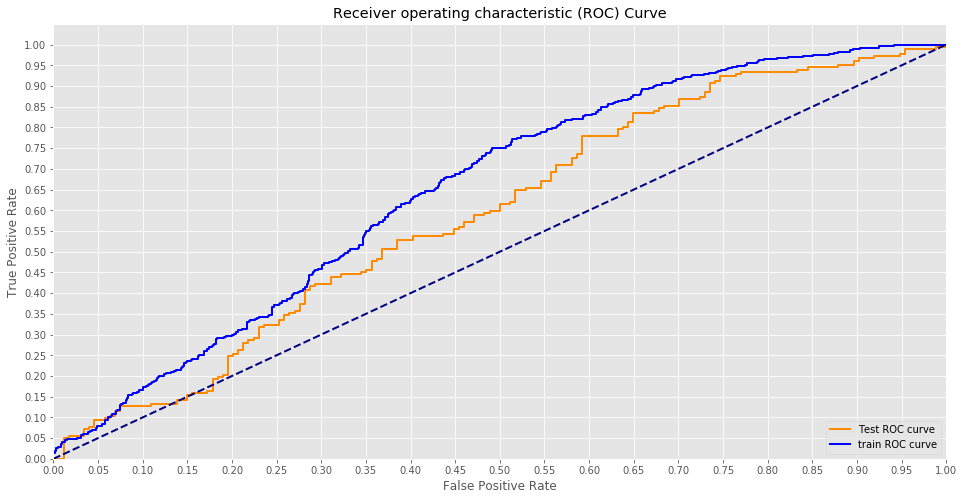

In [186]:
y_test_score  = logreg.decision_function(X_test)
y_train_score = logreg.decision_function(X_train)

# True and False Positive Rates for the Test and Train sets
test_fpr, test_tpr, test_thresholds = roc_curve(y_test, y_test_score)
train_fpr, train_tpr, train_thresholds = roc_curve(y_train, y_train_score)

print("Test AUC:", auc(test_fpr, test_tpr))
print("Train AUC:", auc(train_fpr, train_tpr))

# Plotting
plt.figure(figsize=(16,8))
lw = 2
plt.plot(test_fpr, test_tpr, color='darkorange',
         lw=lw, label='Test ROC curve')
plt.plot(train_fpr, train_tpr, color='blue',
         lw=lw, label='train ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [212]:
# Confusion Matrix from Gridsearch Params
print("Confusion Matrix \n-----------------")
pd.crosstab(y_test, y_pred_gs, rownames=['Actual'], colnames=['Predicted'], margins=True)

Confusion Matrix 
-----------------


Predicted,False,True,All
Actual,,,
False,64,110,174
True,34,148,182
All,98,258,356


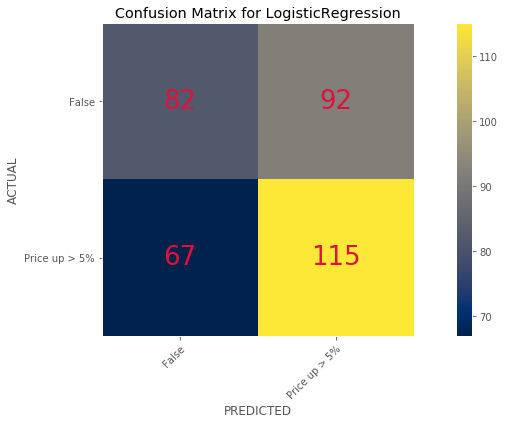

In [221]:
plot_confusion_matrix(y_test, y_pred, title="Confusion Matrix for LogisticRegression")
np.set_printoptions(precision=1)
# Plot non-normalized confusion matrix
plt.savefig('LogRegConMat.png')
plt.show()

### Logistic Regression (w/GridSearch) - Accuracy: 56.46% and F1 Score: 60.15%.